# DTSA 5511 Introduction to Machine Learning: Deep Learning

Final Report: Using Deep Learning to Model Ocean Surface Elevation using
Real World Data

Andrew Simms (University of Colorado Boulder)  
2024-12-09

# 1. Problem Description

Ocean wave prediction is used for maritime safety, wave energy
conversion, and coastal engineering applications. This research explores
deep learning approaches for predicting ocean surface elevation
time-series using historical buoy measurements. While traditional wave
analysis relies on [statistical
parameters](https://www.coastalwiki.org/wiki/Statistical_description_of_wave_parameters)
including significant wave height ($H_{m_0}$) and energy period ($T_e$),
many applications could benefit from more accurate wave-by-wave
predictions of surface elevation.

The need for accurate wave prediction is particularly evident in [wave
energy](https://tethys.pnnl.gov/technology/wave) applications, where
Ringwood (2020) highlights challenges in control system optimization
that depend on reliable wave forecasts. Abdelkhalik et al. (2016)
demonstrates how wave predictions enable real-time optimization of
energy extraction, showing that accurate forecasting directly impacts
system performance and efficiency.

This project addresses the fundamental need for accurate near real-time
wave prediction by developing deep learning models to forecast
three-dimensional surface elevation time-series, focusing on maintaining
both prediction accuracy and computational efficiency through models
trained on previously collected measurements.

## 1.1 Data Sources

The study utilizes surface elevation wave measurements from the [Coastal
Data Information Program (CDIP)](https://cdip.ucsd.edu) focusing on two
strategic United States locations, Kaneohe Bay, Hawaii and Nags Head
North Carolina. These locations were chosen because they have many years
of realtime measurement and the sites have significant seasonal
variations in wave conditions.

<a href="#fig-wave-wets-map" class="quarto-xref">Figure 1</a> shows the
Kaneohe Bay, Hawaii buoy location ([CDIP
225](https://cdip.ucsd.edu/m/products/?stn=225p1)) This buoy is located
within the [U.S. Navy’s Wave Energy Test Site
(WETS)](https://tethys.pnnl.gov/project-sites/us-navy-wave-energy-test-site-wets)
(Coastal Data Information Program 2023a). This deep water deployment at
84m depth experiences a mixed wave climate with trade wind waves, North
Pacific swell, and South Pacific swell. The site generally maintains
consistent wave conditions due to trade wind dominance.

In [1]:
import folium

def create_location_map(latitude, longitude, label, zoom_level=8):
    location_map = folium.Map(location=[latitude, longitude], zoom_start=zoom_level)

    folium.Marker(
        [latitude, longitude],
        popup=label,
        icon=folium.Icon(color="red", icon="info-sign"),
    ).add_to(location_map)

    return location_map

In [2]:
wets_map = create_location_map(
    latitude=21.47740,
    longitude=-157.75684,
    label='CDIP 225 - WETS Hawaii'
)
wets_map

<a href="#fig-wave-nags-head-map" class="quarto-xref">Figure 2</a> shows
the Nags Head, North Carolina buoy location ([CDIP
243](https://cdip.ucsd.edu/m/products/?stn=243p1)) (Coastal Data
Information Program 2023b). This buoy is located near the [Jennettes’s
Pier Wave Energy Test
Center](https://www.coastalstudiesinstitute.org/jptestcenter/). This
site, at an intermediate water depth of 21m, experiences primarily
wind-driven wave conditions. The wave climate is highly variable due to
the influence of Cape Hatteras weather systems, with conditions ranging
from calm seas to severe storm events including tropical cyclones.

In [3]:
nags_head_map = create_location_map(
    latitude= 36.00150,
    longitude=-75.42090,
    label='CDIP 243 - Nags Head NC'
)
nags_head_map

<a href="#tbl-site-compare" class="quarto-xref">Table 1</a> compares the
characteristics of the chosen measurement locations.

| Characteristic | Kaneohe Bay, Hawaii (CDIP 225) | Nags Head, NC (CDIP 243) |
|:-----|-------------------------------------|-----------------------------|
| Water Depth | Deep water (84m) | Intermediate water (21m) |
| Wave Climate | Mixed: trade wind waves, North & South Pacific swell | Primarily wind-driven |
| Wave Conditions | Generally consistent due to trade winds | Highly variable due to Cape Hatteras weather |
| Weather Events | Seasonal variations from Pacific storms | Tropical cyclones, severe storms |
| Research Site | Wave Energy Test Site (WETS) | Jennette’s Pier Wave Energy Test Center |
| CDIP Link | [CDIP 225](https://cdip.ucsd.edu/m/products/?stn=225p1) | [CDIP 243](https://cdip.ucsd.edu/m/products/?stn=243p1) |
| Data Record | Available since 2012 | Available since 2017 |

Table 1: CDIP 225 vs CDIP 243 site comparisons

## 1.2 Data Acquisition Hardware

Surface elevation measurements are collected using Datawell Waverider
DWR-MkIII buoys, detailed in Datawell BV (2006). These specialized
oceanographic instruments capture three-dimensional displacement
measurements at a sampling frequency of 1.28 Hz, providing
high-resolution data of vertical, northward, and eastward wave motion.
All measurements undergo CDIP’s standardized quality control and
processing pipeline before being archived and made available for
analysis.

<figure id="fig-cdip-cook-inlet">
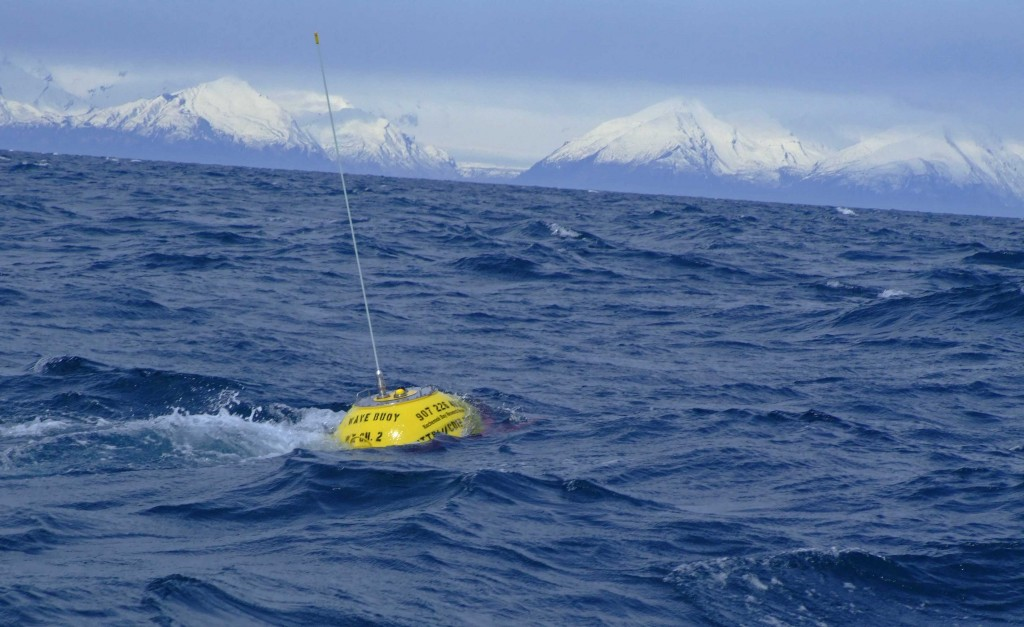
<figcaption>Figure 3: CDIP Buoy 204 Deployed in Lower Cook Inlet Alaska.
Photo from <a
href="https://legacy.aoos.org/cook-inlet-wave-buoy-up-and-running/">AOOS</a></figcaption>
</figure>

### 1.2.1 Directional Reference Frame

As illustrated in
<a href="#fig-buoy-movement" class="quarto-xref">Figure 4</a>, the
buoy’s movement is tracked in a three-dimensional reference frame,
measuring displacements in vertical (Z), east-west (X), and north-south
(Y) directions. Our prediction task focuses on forecasting these three
displacement components in real-time as measurement data streams from
the buoy. This multivariate time series prediction approach uses
historical measurements of all three displacement components to forecast
their future values over specified time horizons, providing a
comprehensive representation of wave motion at each location.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set_theme()

# Get a pleasing color palette
# colors = sns.color_palette("husl", 3)  # Using husl for distinct but harmonious colors
colors = sns.color_palette()
x_color = colors[0]
y_color = colors[1]
z_color = colors[2]

# Create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 0.4 * np.outer(np.cos(u), np.sin(v))
y = 0.4 * np.outer(np.sin(u), np.sin(v))
z = 0.4 * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot semi-transparent sphere
ax.plot_surface(x, y, z, color='orange', alpha=0.3)

# Plot axes through sphere center
length = 0.6
ax.plot([-length, length], [0, 0], [0, 0], color=x_color, linewidth=2, label='X (East/West)')
ax.plot([0, 0], [-length, length], [0, 0], color=y_color, linewidth=2, label='Y (True North/South)')
ax.plot([0, 0], [0, 0], [-length, length], color=z_color, linewidth=2, label='Z (Vertical)')

# Add arrows at the ends
arrow_length = 0.1
# X axis arrows
ax.quiver(length, 0, 0, arrow_length, 0, 0, color=x_color, arrow_length_ratio=0.3)
ax.quiver(-length, 0, 0, -arrow_length, 0, 0, color=x_color, arrow_length_ratio=0.3)
# Y axis arrows
ax.quiver(0, length, 0, 0, arrow_length, 0, color=y_color, arrow_length_ratio=0.3)
ax.quiver(0, -length, 0, 0, -arrow_length, 0, color=y_color, arrow_length_ratio=0.3)
# Z axis arrows
ax.quiver(0, 0, length, 0, 0, arrow_length, color=z_color, arrow_length_ratio=0.3)
ax.quiver(0, 0, -length, 0, 0, -arrow_length, color=z_color, arrow_length_ratio=0.3)


# Set equal aspect ratio
ax.set_box_aspect([1,1,1])

# Set axis limits
limit = 0.55
ax.set_xlim([-limit, limit])
ax.set_ylim([-limit, limit])
ax.set_zlim([-limit, limit])

# Add grid
ax.grid(True, alpha=0.3)

# Add axis labels with matching colors
ax.set_xlabel('East/West Displacement (X) [m]', color=x_color, weight='bold', fontsize=18)
ax.set_ylabel('True North/South Displacement (Y) [m]', color=y_color, weight='bold', fontsize=18)
ax.set_zlabel('Vertical Displacement (Z) [m]', color=z_color, weight='bold', fontsize=18)

# Adjust view angle
ax.view_init(elev=20, azim=180 - 45)

# Set background color to white
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.show()

## 1.3 Deep Learning Architecture Overview

This project leverages both Long Short-Term Memory (LSTM) networks and
Transformer architectures to predict ocean surface elevation
measurements. LSTMs, first introduced by Hochreiter and Schmidhuber
(1997), have demonstrated success in temporal sequence learning through
their ability to capture long-term dependencies. The Transformer
architecture, developed by Vaswani et al. (2023), offers an alternative
approach using self-attention mechanisms to process sequential data
without recurrence.

Previous work in ocean wave forecasting has shown promise using neural
network approaches. Mandal and Prabaharan (2006) demonstrated effective
wave height prediction using recurrent neural networks, while Kumar,
Savitha, and Mamun (2017) explored sequential learning algorithms for
regional wave height forecasting. Building on these foundations, our
approach implements both LSTM and Transformer models using the PyTorch
framework by Ansel et al. (2024), and the [LSTM
Module](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
described by Sak, Senior, and Beaufays (2014), allowing for direct
comparison of their performance in predicting three-dimensional surface
elevation time series.

## 1.4 Project Workflow

<figure id="fig-proj-work-complete">
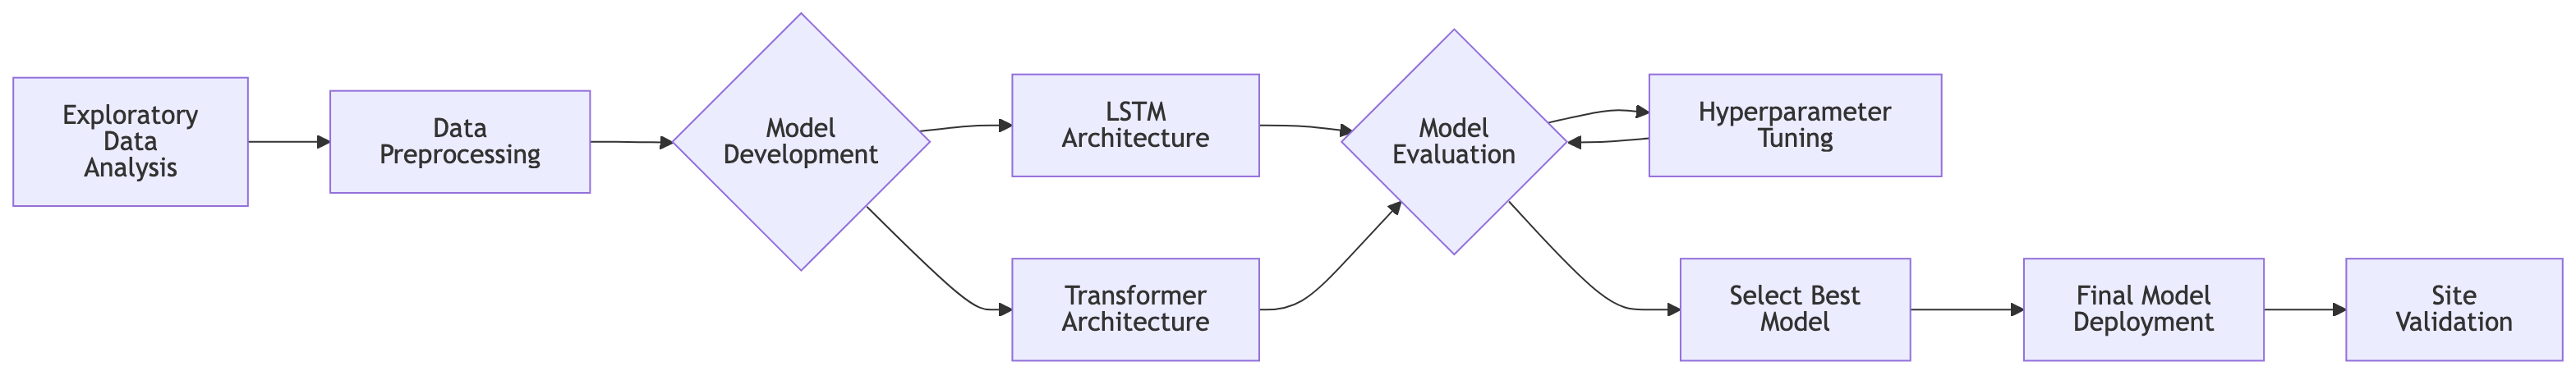
<figcaption>Figure 5: Wave Prediction Modeling Workflow</figcaption>
</figure>

The workflow in
<a href="#fig-proj-work-complete" class="quarto-xref">Figure 5</a> is a
systematic deep learning workflow optimized for wave prediction
modeling. Beginning with exploratory data analysis of CDIP buoy
measurements, the data undergoes preprocessing including normalization
and temporal windowing. The model development phase explores multiple
neural network architectures in parallel, followed by rigorous
evaluation and hyperparameter tuning. The final model undergoes
cross-site validation to assess its generalization capabilities across
different ocean environments.

# 2. Exploratory Data Analysis

## 2.1 Displacement Measurement

Ocean wave measurements from CDIP buoys utilize sophisticated sensor
arrays including accelerometers, magnetometers, and GPS sensors to track
three-dimensional wave motion Datawell BV (2006). These instruments
output vertical displacement (commonly referred to as surface
elevation), along with northward and eastward displacements. Figure
<a href="#fig-displacement" class="quarto-xref">Figure 6</a> illustrates
these three displacement components using a 30-minute sample from CDIP
225, demonstrating the typical wave motion captured by a Datawell
Waverider buoy.

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
df = pd.read_parquet("../data/a2_std_partition/station_number=0225/year=2017/month=11/day=11/hour=11/minute=00/data_20171111_1100.parquet")

df['vert_displacement_meters'].plot(figsize=(9, 2), linewidth=0.85, xlabel="Time", ylabel="Vertical\nDisplacement [m]")
plt.show()

df['north_displacement_meters'].plot(figsize=(9, 2), linewidth=0.85, xlabel="Time", ylabel="North/South\nDisplacement [m]")
plt.show()

df['east_displacement_meters'].plot(figsize=(9, 2), linewidth=0.85, xlabel="Time", ylabel="East/West\nDisplacement [m]")
plt.show()

In <a href="#fig-displacement-zoomed" class="quarto-xref">Figure 7</a>,
a detailed view of approximately 90 seconds of the same time series
reveals the fine-scale structure of wave motion. While the overall
pattern exhibits typical wave behavior, the vertical displacement shows
distinct non-sinusoidal characteristics, particularly during directional
transitions. These abrupt changes in vertical motion highlight the
complex, non-linear nature of real ocean waves compared to idealized
wave forms.

In [6]:
sns.set_theme()
df = pd.read_parquet("../data/a2_std_partition/station_number=0225/year=2017/month=11/day=11/hour=11/minute=00/data_20171111_1100.parquet")

end_index = int(288 / 2) # 2304 / 2 / 2 / 2 - ~3 minutes / 2 = 90 seconds

df['vert_displacement_meters'].iloc[:end_index].plot(figsize=(9, 2), linewidth=0.85, xlabel="Time", ylabel="Vertical\nDisplacement [m]", marker=".", markersize=2)
plt.show()

df['north_displacement_meters'].iloc[:end_index].plot(figsize=(9, 2), linewidth=0.85, xlabel="Time", ylabel="North/South\nDisplacement [m]", marker=".", markersize=2)
plt.show()
df['east_displacement_meters'].iloc[:end_index].plot(figsize=(9, 2), linewidth=0.85, xlabel="Time", ylabel="East/West\nDisplacement [m]", marker=".", markersize=2)
plt.show()

## 2.2 Data Source and Download

The displacement data used in this study was obtained from CDIP’s
THREDDS data server. Data for both locations - the Wave Energy Test Site
([CDIP
225](https://thredds.cdip.ucsd.edu/thredds/catalog/cdip/archive/225p1/catalog.html))
and Nags Head ([CDIP
243](https://thredds.cdip.ucsd.edu/thredds/catalog/cdip/archive/243p1/catalog.html)) -
is hosted on CDIP’s archive server with standardized [displacement time
series
documentation](https://cdip.ucsd.edu/themes/media/docs/documents/html_pages/dw_timeseries.html).
The data is provided in NetCDF format.

Each data file contains three-dimensional displacement measurements
sampled at 1.28 Hz, along with corresponding quality control flags. The
raw NetCDF files were processed using [xarray](https://xarray.dev) by
Hoyer and Joseph (2017) for efficient handling of the multidimensional
data. Timestamps were generated according to CDIP specifications,
accounting for sampling rates and filter delays. The processed
measurements were then consolidated into pandas DataFrames, developed by
The pandas development team (n.d.), and stored in parquet format for
efficient access during model development.

    from pathlib import Path

    import requests
    import xarray as xr
    import numpy as np
    import pandas as pd
    import seaborn as sns

    sns.set_theme()

    # NAGS HEAD, NC - 243
    # station_number = "243"
    # KANEOHE BAY, WETS, HI - 225
    station_number = "225"
    # 1.28 hz * 30
    SAMPLES_PER_HALF_HOUR = 2304


    def get_cdip_displacement_df(station_number, dataset_number):
        fname = f"{station_number}p1_d{dataset_number}.nc"

        nc_path = Path(f"./data/00_raw/{fname}").resolve()
        print(f"Opening {nc_path} if it exists...")

        if nc_path.exists() is False:
            nc_url = f"https://thredds.cdip.ucsd.edu/thredds/fileServer/cdip/archive/{station_number}p1/{fname}"
            print("Downloading", nc_url)
            # Download the NetCDF file using requests
            response = requests.get(nc_url)
            with open(nc_path, "wb") as f:
                f.write(response.content)

        # Open the downloaded NetCDF file with xarray
        ds = xr.open_dataset(nc_path)

        # Extract the relevant variables from the dataset
        xdisp = ds["xyzXDisplacement"]  # North/South Displacement (X)
        ydisp = ds["xyzYDisplacement"]  # East/West Displacement (Y)
        zdisp = ds["xyzZDisplacement"]  # Vertical Displacement (Z)
        qc_flag = ds["xyzFlagPrimary"]  # Quality control flag

        # For some reason all of these are missing one sample. So we remove the last section

        xdisp = xdisp[:-(SAMPLES_PER_HALF_HOUR)]
        ydisp = ydisp[:-(SAMPLES_PER_HALF_HOUR)]
        zdisp = zdisp[:-(SAMPLES_PER_HALF_HOUR)]
        qc_flag = qc_flag[:-(SAMPLES_PER_HALF_HOUR)]

        filter_delay = ds["xyzFilterDelay"].values
        start_time = ds["xyzStartTime"].values  # Start time of buoy data collection
        sample_rate = float(
            ds["xyzSampleRate"].values
        )  # Sample rate of buoy data collection
        sample_rate = round(sample_rate, 2)
        print(
            f"Station Number: {station_number}, dataset_number: {dataset_number}, sample_rate: {sample_rate}"
        )

        print(f"Len xdisp: {len(xdisp)}, num 30 min sections = {(len(xdisp) + 1) / 2304}")
        print(f"Filter delay: {filter_delay}")

        sample_delta_t_seconds = 1 / sample_rate
        sample_delta_t_nanoseconds = sample_delta_t_seconds * 1e9
        n_times = len(xdisp)

        start_time_ns = start_time.astype("int64")

        start_time_ns = start_time.astype("int64")  # Convert start_time to nanoseconds
        # start_time_ns -= filter_delay * 1e9
        time_increments = (
            np.arange(n_times) * sample_delta_t_nanoseconds
        )  # Create an array of time increments
        times = start_time_ns + time_increments

        time = pd.to_datetime(times, unit="ns", origin="unix", utc=True)  # type: ignore

        df = pd.DataFrame(
            {
                "north_displacement_meters": xdisp,
                "east_displacement_meters": ydisp,
                "vert_displacement_meters": zdisp,
                "qc_displacement": qc_flag,
            },
            index=time,
        )

        return df


    station_number = "225"
    station_number = "243"
    df_1 = get_cdip_displacement_df(station_number, "01")
    df_2 = get_cdip_displacement_df(station_number, "02")
    df_3 = get_cdip_displacement_df(station_number, "03")
    df_4 = get_cdip_displacement_df(station_number, "04")
    # df_5 = get_cdip_displacement_df(station_number, "05")

    # df_all = pd.concat([df_1, df_2, df_3, df_4, df_5], axis="index")
    df_all = pd.concat([df_1, df_2, df_3, df_4], axis="index")
    # df_all = pd.concat([df_1, df_2, df_3], axis="index")
    df_all = df_all.sort_index()

    df_all.to_parquet(f"./data/a1_one_to_one_parquet/{station_number}_all.parquet")

    print(df_all.info())

    print(f"Successfully saved {station_number}_all.parquet!")

Listing 1: CDIP Download Implementation

The CDIP download, shown in
<a href="#lst-cdip-download" class="quarto-xref">Listing 1</a>,
demonstrates the automated download and processing pipeline. This code
handles the retrieval of NetCDF files, extraction of displacement
measurements, timestamp generation, and data organization into a
structured format suitable for analysis and model training. Quality
control flags are preserved throughout the processing pipeline to ensure
data integrity.

## 2.3 Available Data

This section examines the temporal extent and characteristics of the
available wave measurements.

### 2.3.1 Duration

In [8]:
first_225 = pd.read_parquet("../data/a2_std_partition/station_number=0225/year=2016/month=08/day=26/hour=22/minute=00/data_20160826_2200.parquet")
first_225_timestamp = first_225.index[0]
first_225_timestamp
last_225 = pd.read_parquet("../data/a2_std_partition/station_number=0225/year=2024/month=09/day=11/hour=18/minute=30/data_20240911_1830.parquet")
last_225_timestamp = last_225.index[-1]
last_225_timestamp
first_243 = pd.read_parquet("../data/a2_std_partition/station_number=0243/year=2018/month=08/day=26/hour=15/minute=00/data_20180826_1500.parquet")
first_243_timestamp = first_243.index[0]
first_243_timestamp

last_243 = pd.read_parquet("../data/a2_std_partition/station_number=0243/year=2023/month=07/day=12/hour=23/minute=30/data_20230712_2330.parquet")
last_243_timestamp = last_243.index[-1]
last_243_timestamp

from datetime import datetime

# Create the data
data = {
    'station': ['225', '243'],
    'start_date': [
        first_225_timestamp,
        first_243_timestamp,
    ],
    'end_date': [
        last_225_timestamp,
        last_243_timestamp,
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate duration
df['duration'] = df['end_date'] - df['start_date']

# Function to format duration in human readable format
def format_duration(timedelta):
    years = timedelta.days // 365
    remaining_days = timedelta.days % 365
    months = remaining_days // 30
    days = remaining_days % 30

    parts = []
    if years > 0:
        parts.append(f"{years} {'year' if years == 1 else 'years'}")
    if months > 0:
        parts.append(f"{months} {'month' if months == 1 else 'months'}")
    if days > 0:
        parts.append(f"{days} {'day' if days == 1 else 'days'}")

    return ", ".join(parts)

# Add human readable duration
df['duration_human'] = df['duration'].apply(format_duration)

# Format datetime columns to be more readable
df['start_date'] = df['start_date'].dt.strftime('%Y-%m-%d %H:%M')
df['end_date'] = df['end_date'].dt.strftime('%Y-%m-%d %H:%M')

df = df.rename({
    'start_date': "Start Date [UTC]",
    'end_date': "End Date [UTC]",
    'duration_human': "Duration",
}, axis="columns")

``` python
df[['Start Date [UTC]', 'End Date [UTC]', 'Duration']]
```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|     | Start Date \[UTC\] | End Date \[UTC\] | Duration                    |
|-----|--------------------|------------------|-----------------------------|
| 0   | 2016-08-26 22:00   | 2024-09-11 19:00 | 8 years, 17 days            |
| 1   | 2018-08-26 15:00   | 2023-07-13 00:00 | 4 years, 10 months, 21 days |

</div>

Table 2: Temporal Details of Downloaded CDIP Data

Based the information in
<a href="#tbl-duration" class="quarto-xref">Table 2</a>, the CDIP buoy
datasets provide extensive coverage for both locations: WETS (CDIP 225)
spans approximately 8 years (2016-2024), while Nags Head (CDIP 243)
covers nearly 5 years (2018-2023). Both datasets contain
three-dimensional displacement measurements at 1.28 Hz sampling
frequency.

## 2.4 Displacement Statistics

For each location, we analyzed the statistical characteristics of the
three-dimensional displacement measurements.

In [10]:
import duckdb
import os

def calculate_column_stats(partition_path, column_name):
    con = duckdb.connect()
    con.execute("SET enable_progress_bar = false;")

    query = f"""
    SELECT
        '{column_name}' as column_name,
        COUNT({column_name}) as count,
        COUNT(DISTINCT {column_name}) as unique_count,
        SUM(CASE WHEN {column_name} IS NULL THEN 1 ELSE 0 END) as null_count,
        MIN({column_name}) as min_value,
        MAX({column_name}) as max_value,
        AVG({column_name}::DOUBLE) as mean,
        STDDEV({column_name}::DOUBLE) as std_dev,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY {column_name}::DOUBLE) as q1,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY {column_name}::DOUBLE) as median,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY {column_name}::DOUBLE) as q3
    FROM read_parquet('{partition_path}/**/*.parquet', hive_partitioning=true)
    WHERE {column_name} IS NOT NULL
    """

    stats_df = con.execute(query).df()
    con.close()
    return stats_df

def analyze_displacement_data(base_path, columns_to_analyze, station_numbers, output_path, overwrite=False):
    # Check if stats file already exists
    if os.path.exists(output_path) and not overwrite:
        return pd.read_parquet(output_path)

    all_stats = []

    for station in station_numbers:
        station_str = f"{station:04d}"  # Format station number with leading zeros
        partition_path = f"{base_path}/station_number={station_str}"

        if not os.path.exists(partition_path):
            print(f"Skipping station {station_str} - path does not exist")
            continue

        print(f"Processing station {station_str}...")

        for column in columns_to_analyze:
            try:
                stats_df = calculate_column_stats(partition_path, column)
                stats_df['station'] = station_str
                all_stats.append(stats_df)
                print(f"  Completed analysis of {column}")
            except Exception as e:
                print(f"  Error processing {column} for station {station_str}: {str(e)}")

    # Combine all results
    if all_stats:
        combined_stats = pd.concat(all_stats, ignore_index=True)

        # Create output directory if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Save to parquet
        combined_stats.to_parquet(output_path, index=False)
        print(f"\nStatistics saved to {output_path}")
        return combined_stats
    else:
        print("No statistics were generated")
        return None

# Example usage
base_path = "../data/a2_std_partition"
columns_to_analyze = [
    "vert_displacement_meters",
    "north_displacement_meters",
    "east_displacement_meters"
]
station_numbers = [225, 243]  # Add more station numbers as needed
output_path = "../data/displacement_stats.parquet"

# Run the analysis - will load existing file if it exists
stats_df = analyze_displacement_data(
    base_path=base_path,
    columns_to_analyze=columns_to_analyze,
    station_numbers=station_numbers,
    output_path=output_path,
    overwrite=False  # Set to True to force recalculation
)

stats_df["Range [m]"] = stats_df['max_value'] + stats_df['min_value'].abs()

# stats_df.loc[stats_df['column_name'] == 'vert_displacement_meters'] = "Vertical Displacement [m]"
stats_df.loc[stats_df['column_name'] == 'vert_displacement_meters', 'column_name'] = "Vertical Displacement [m]"
stats_df.loc[stats_df['column_name'] == 'north_displacement_meters', 'column_name'] = "North/South Displacement [m]"
stats_df.loc[stats_df['column_name'] == 'east_displacement_meters', 'column_name'] = "East/West Displacement [m]"

stats_df.loc[stats_df['station'] == '0225', 'station'] = "225 - Kaneohe Bay, HI"
stats_df.loc[stats_df['station'] == '0243', 'station'] = "243 - Nags Head, NC"
# stats_df = stats_df.rename(columns={'vert_displacement_meters': 'Vertical Displacement [m]'})

stats_df = stats_df.rename({
    "count": "Count",
    "min_value": "Min [m]",
    "max_value": "Max [m]",
    "mean": "Mean [m]",
    "std_dev": "Standard Deviation [m]",
}, axis="columns")

# stats_df

In [11]:
import matplotlib

matplotlib.rcParams["axes.formatter.limits"] = (-99, 99)


def plot_stat(this_stat_df, stat_column, decimals=2):
    plt.figure(figsize=(9, 3))
    plt.gca().yaxis.set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
    )
    ax = sns.barplot(this_stat_df, x="station", y=stat_column, hue="column_name")

    for container in ax.containers:
        ax.bar_label(container, fmt=f"%.{decimals}f", padding=3, fontsize=7)

    plt.xlabel(None)
    # Move legend below the plot, set to 3 columns, remove box
    plt.legend(
        bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=3, frameon=False, title=""
    )

``` python
plot_stat(stats_df, 'Count', decimals=0)
```

<figure id="fig-stats-count">
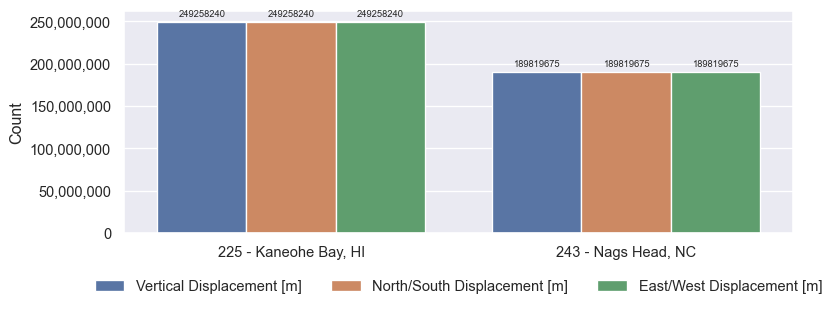
<figcaption>Figure 8: Available Data: Sample Count</figcaption>
</figure>

``` python
plot_stat(stats_df, 'Range [m]')
```

<figure id="fig-stats-range">
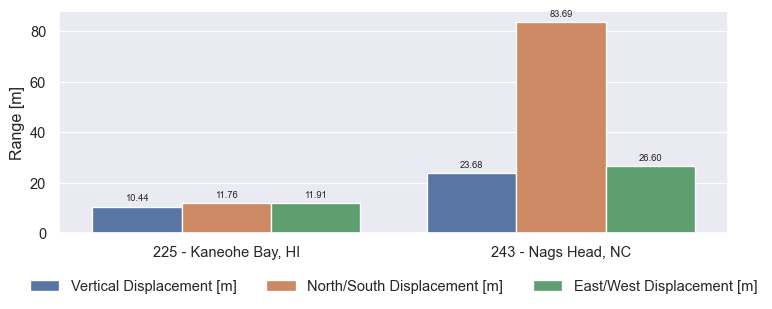
<figcaption>Figure 9: Available Data: Range [m]</figcaption>
</figure>

``` python
plot_stat(stats_df, 'Max [m]')
```

<figure id="fig-stats-max">
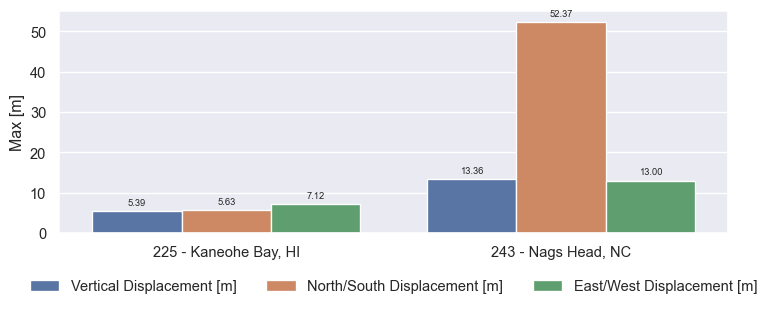
<figcaption>Figure 10: Available Data: Maximum [m]</figcaption>
</figure>

``` python
plot_stat(stats_df, 'Min [m]')
```

<figure id="fig-stats-min">
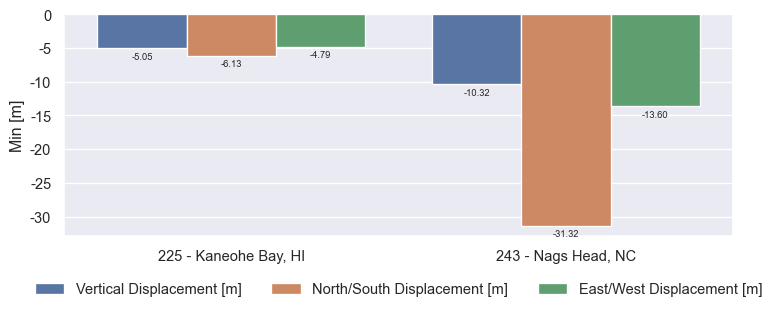
<figcaption>Figure 11: Available Data: Minimum [m]</figcaption>
</figure>

``` python
plot_stat(stats_df, 'Standard Deviation [m]')
```

<figure id="fig-stats-std">
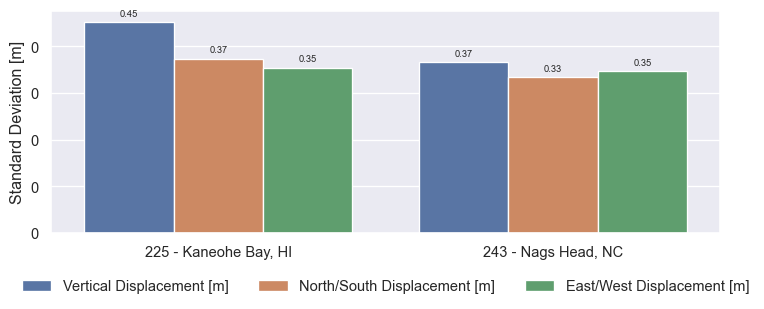
<figcaption>Figure 12: Available Data: Standard Deviation
[m]</figcaption>
</figure>

<a href="#fig-stats-range" class="quarto-xref">Figure 9</a> shows that
at WETS (CDIP 225), vertical displacements range approximately
$\pm5\,\mathrm{m}$, while north-south and east-west displacements show
similar ranges of about $\pm6\,\mathrm{m}$. The Nags Head site (CDIP
243) experiences larger displacement ranges, with vertical motion
reaching $\pm13\,\mathrm{m}$ and horizontal displacements extending up
to $\pm52\,\mathrm{m}$, reflecting its more dynamic wave climate. All
displacement components at both locations show near-zero means with
standard deviations between $0.33$ and $0.45\,\mathrm{m}$, indicating
symmetric wave motion about the mean position. The anomalous
$52\,\mathrm{m}$ range in horizontal displacement at Nags Head suggests
potential outliers or measurement artifacts that should be filtered
prior to model training to ensure data quality.

## 2.5 Partitioning Data

## 2.6 Data Partitioning

To facilitate efficient data handling and model development, we
partitioned the continuous time series into 30-minute segments using a
hierarchical storage structure. Each segment contains 2,304 samples
(corresponding to the 1.28 Hz sampling rate) and is organized using a
[hive partitioning
strategy](https://duckdb.org/docs/data/partitioning/hive_partitioning.html)
based on temporal metadata (year, month, day, hour, minute) and station
number.

The implementation, shown in
<a href="#lst-partition" class="quarto-xref">Listing 2</a>, creates a
systematic file structure where each 30-minute measurement period is
stored as an individual parquet file. This organization enables
efficient data loading during model training and validation, while
maintaining the temporal relationship between segments. The hierarchical
structure also facilitates parallel processing and selective data
loading based on specific time periods or stations.

## 2.7 Calculating Statistical Wave Parameters

The original multi year displacement data volume is too large to train a
model for this project. As such we need to subset the problem. To do
this we will use MHKiT-Python by Fao et al. (2024) to transform the
surface elevations into 30 minute statistics of wave measurements. These
are easier to visualize and understand the wave characteristics.

Transforming raw displacement measurements into 30-minute statistical
wave parameters using MHKiT-Python Fao et al. (2024) provides a clearer
view of the wave conditions at each site. These statistical metrics -
significant wave height ($H_{m_0}$), energy period ($T_e$), and
omnidirectional wave energy flux ($J$) - help identify unique wave
conditions and temporal patterns within the large dataset.

The implementation shown in
<a href="#lst-mhkit" class="quarto-xref">Listing 3</a> computes these
wave parameters.

In [19]:
qoi_225 = pd.read_parquet("../data/b2_wave_qoi_stats/qoi_225.parquet")
qoi_243 = pd.read_parquet("../data/b2_wave_qoi_stats/qoi_243.parquet")

``` python
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


def compare_qoi_over_time(qoi, label):
    figsize = (8, 3)
    xlabel = "Time"
    qoi_225[qoi].plot(
        figsize=figsize, xlabel=xlabel, ylabel=label, linewidth=0.75
    )
    plt.show()

    qoi_243[qoi].plot(
        figsize=figsize, xlabel=xlabel, ylabel=label, linewidth=0.75
    )
    plt.show()

compare_qoi_over_time('significant_wave_height_meters', "$H_{m_0}$ [$m$]")
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-hm0-1">
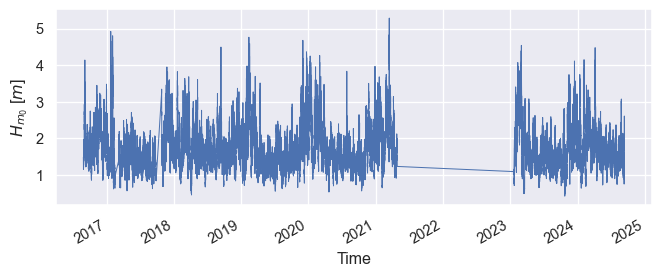
<figcaption>(a) Wave Energy Test Site - Hawaii</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-hm0-2">
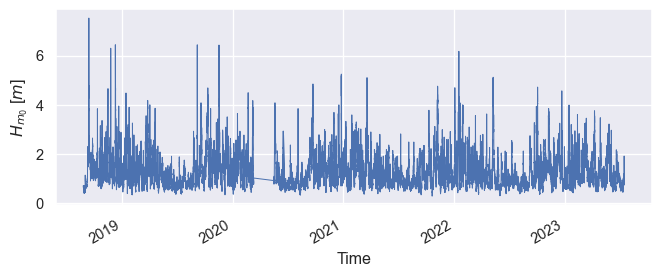
<figcaption>(b) Nags Head - North Carolina</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 13: Significant Wave Height, $H_{m_0}$ \[$m$\]

``` python
compare_qoi_over_time('energy_period_seconds', "$T_e$ [$s$]")
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-te-1">
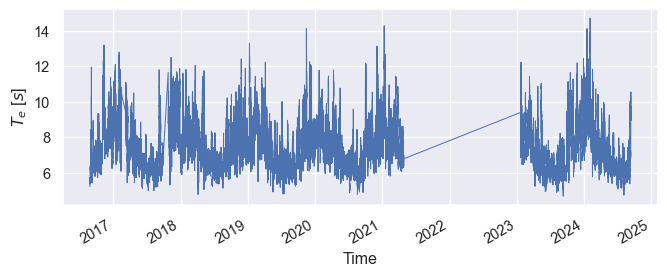
<figcaption>(a) Wave Energy Test Site - Hawaii</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-te-2">
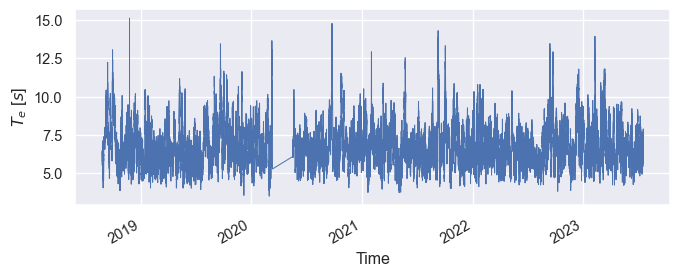
<figcaption>(b) Nags Head - North Carolina</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 14: Energy Period, $T_e$ \[$s$\]

``` python
compare_qoi_over_time('omnidirectional_wave_energy_flux', "$J$ [$W/m$]")
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-j-1">
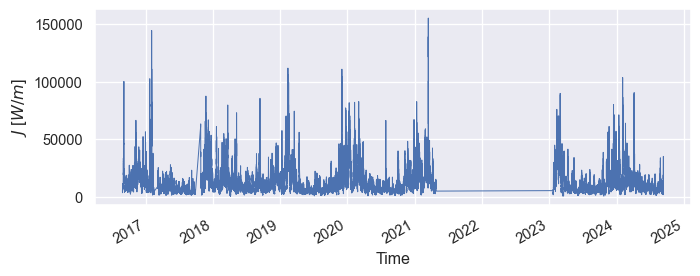
<figcaption>(a) Wave Energy Test Site - Hawaii</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-j-2">
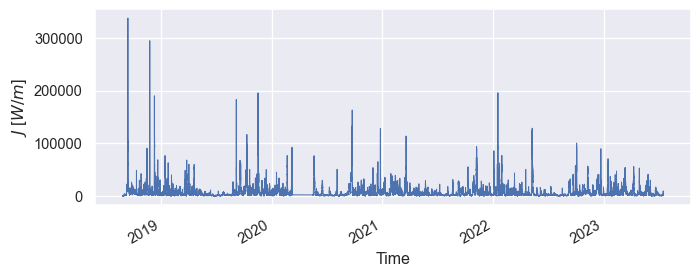
<figcaption>(b) Nags Head - North Carolina</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 15: Omnidirectional Wave Energy Flux (Wave Power), $J$ \[$W/m$\]

``` python
start_date = "2019-01-01 00:00:00"
end_date = "2019-12-31 23:59:59.9999"

qoi_225 = qoi_225.loc[start_date:end_date]
qoi_243 = qoi_243.loc[start_date:end_date]


compare_qoi_over_time('significant_wave_height_meters', "$H_{m_0}$ [$m$]")
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-hm0-2019-1">
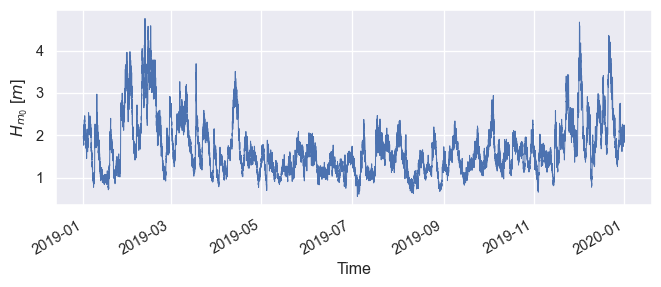
<figcaption>(a) Wave Energy Test Site - Hawaii</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-hm0-2019-2">
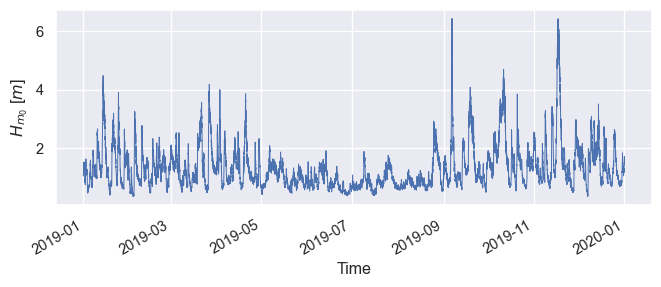
<figcaption>(b) Nags Head - North Carolina</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 16: Significant Wave Height, $H_{m_0}$ \[$m$\]

``` python
compare_qoi_over_time('energy_period_seconds', "$T_e$ [$s$]")
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-te-2019-1">
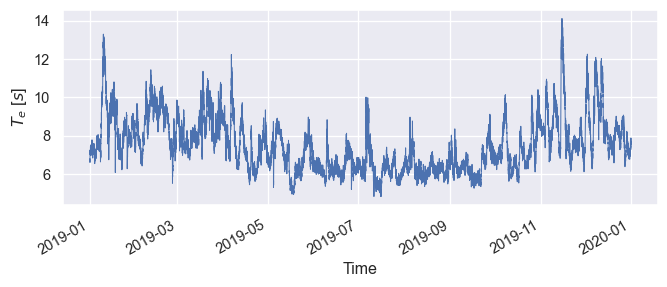
<figcaption>(a) Wave Energy Test Site - Hawaii</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-te-2019-2">
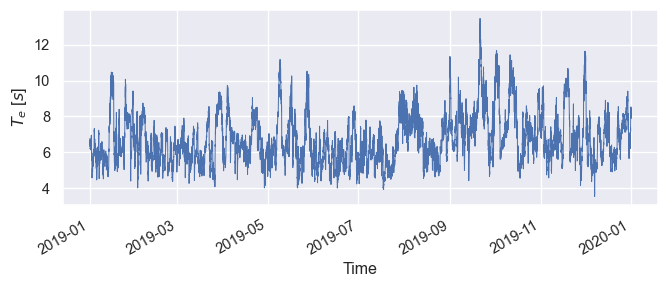
<figcaption>(b) Nags Head - North Carolina</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 17: Energy Period, $T_e$ \[$s$\]

``` python
compare_qoi_over_time('omnidirectional_wave_energy_flux', "$J$ [$W/m$]")
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-j-2019-1">
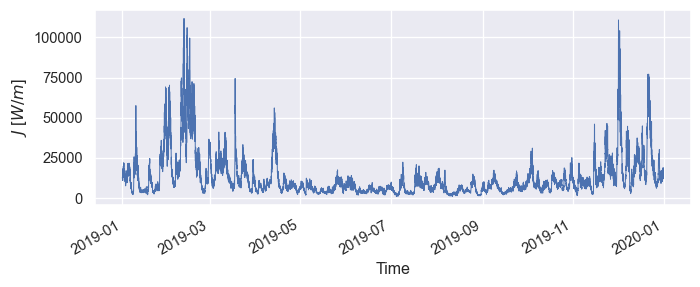
<figcaption>(a) Wave Energy Test Site - Hawaii</figcaption>
</figure>
</div></td>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="50.0%"
data-layout-align="left">
<figure id="fig-wave-stats-j-2019-2">
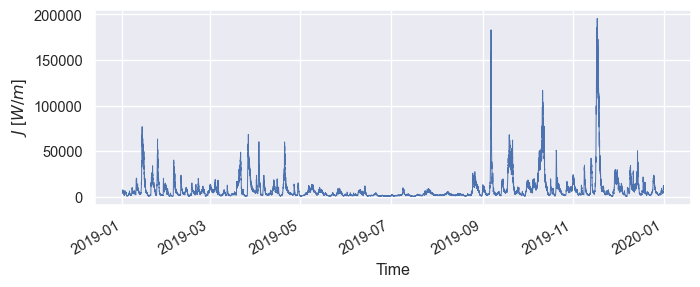
<figcaption>(b) Nags Head - North Carolina</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 18: Omnidirectional Wave Energy Flux (Wave Power), $J$ \[$W/m$\]

As shown in
<a href="#fig-wave-stats-hm0" class="quarto-xref">Figure 13</a> through
<a href="#fig-wave-stats-j" class="quarto-xref">Figure 15</a>, WETS
(CDIP 225) exhibits more periodic behavior while Nags Head (CDIP 243)
shows greater variability. A notable data gap exists in the WETS
measurements from 2021 to 2023. Focusing on 2019
(<a href="#fig-wave-stats-hm0-2019" class="quarto-xref">Figure 16</a>
through
<a href="#fig-wave-stats-j-2019" class="quarto-xref">Figure 18</a>)
highlights that Nags Head experiences higher peak wave power and wave
heights but a narrower range of wave periods compared to WETS. These
insights will guide our selection of representative data segments for
model development.

## 2.8 Sea State Analysis

To understand the distribution of wave conditions at each site, we
developed sea state matrices that bin the data by significant wave
height ($H_{m_0}$) and energy period ($T_e$). This categorization
quantifies the frequency of different wave conditions and helps ensure
our training dataset encompasses a representative range of height and
period states.

In [26]:
import numpy as np

def plot_wave_heatmap(df, figsize=(12, 8)):
    # Create bins for Hm0 and Te
    hm0_bins = np.arange(0, df['significant_wave_height_meters'].max() + 0.5, 0.5)
    te_bins = np.arange(0, df['energy_period_seconds'].max() + 1, 1)

    # Use pd.cut to bin the data
    hm0_binned = pd.cut(df['significant_wave_height_meters'],
                        bins=hm0_bins,
                        labels=hm0_bins[:-1],
                        include_lowest=True)

    te_binned = pd.cut(df['energy_period_seconds'],
                       bins=te_bins,
                       labels=te_bins[:-1],
                       include_lowest=True)

    # Create cross-tabulation of binned data
    counts = pd.crosstab(hm0_binned, te_binned)

    counts = counts.sort_index(ascending=False)


    # Replace 0 counts with NaN
    counts = counts.replace(0, np.nan)

    # Create figure and axis
    plt.figure(figsize=figsize)

    # Create heatmap using seaborn
    ax = sns.heatmap(
        counts,
        cmap='viridis',
        annot=True,  # Add count annotations
        fmt='.0f',   # Format annotations as integers
        cbar_kws={'label': 'Count'},
    )

    # Customize plot
    plt.xlabel('Energy Period Te (s)')
    plt.ylabel('Significant Wave Height Hm0 (m)')

    # Rotate x-axis labels for better readability
    # plt.xticks(rotation=45)
    plt.yticks(rotation=90)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

In [27]:
qoi_225 = pd.read_parquet("../data/b2_wave_qoi_stats/qoi_225.parquet")
qoi_243 = pd.read_parquet("../data/b2_wave_qoi_stats/qoi_243.parquet")

``` python
plot_wave_heatmap(qoi_225)
```

<figure id="fig-wave-stats-225-count">
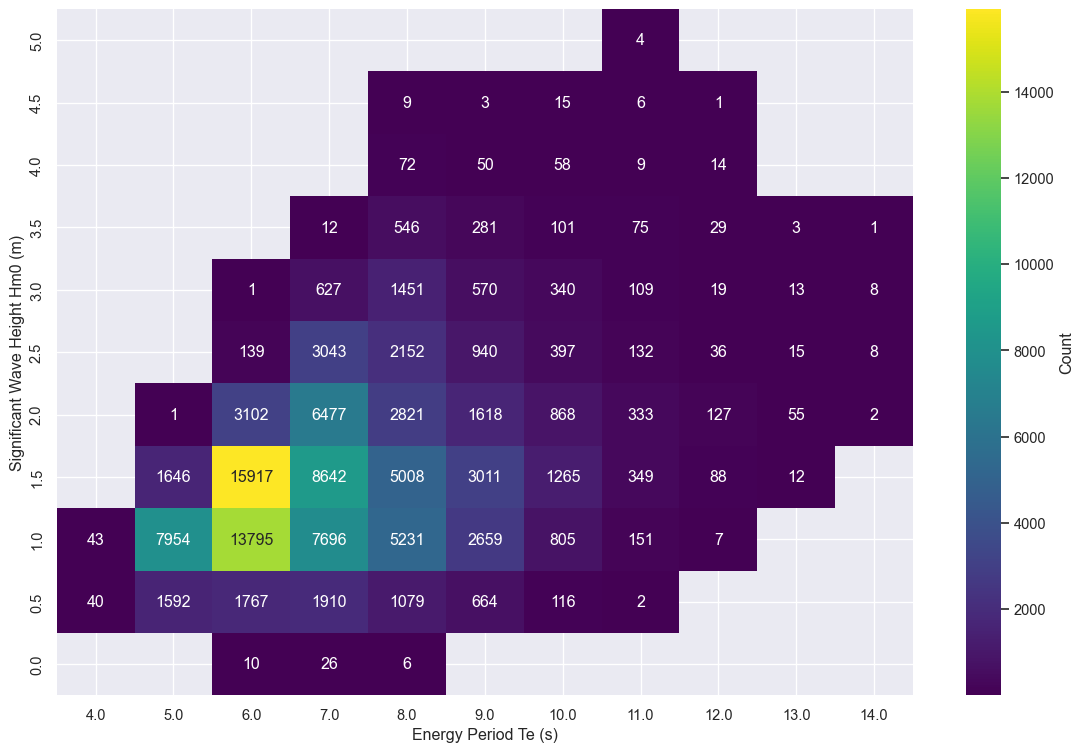
<figcaption>Figure 19: Distribution of Sea States at WETS (CDIP 225),
Showing Occurrence Count of Combined Significant Wave Height (<span
class="math inline"><em>H</em><sub><em>m</em><sub>0</sub></sub></span>)
and Energy Period (<span
class="math inline"><em>T</em><sub><em>e</em></sub></span>)
Conditions</figcaption>
</figure>

``` python
plot_wave_heatmap(qoi_243)
```

<figure id="fig-wave-stats-243-count">
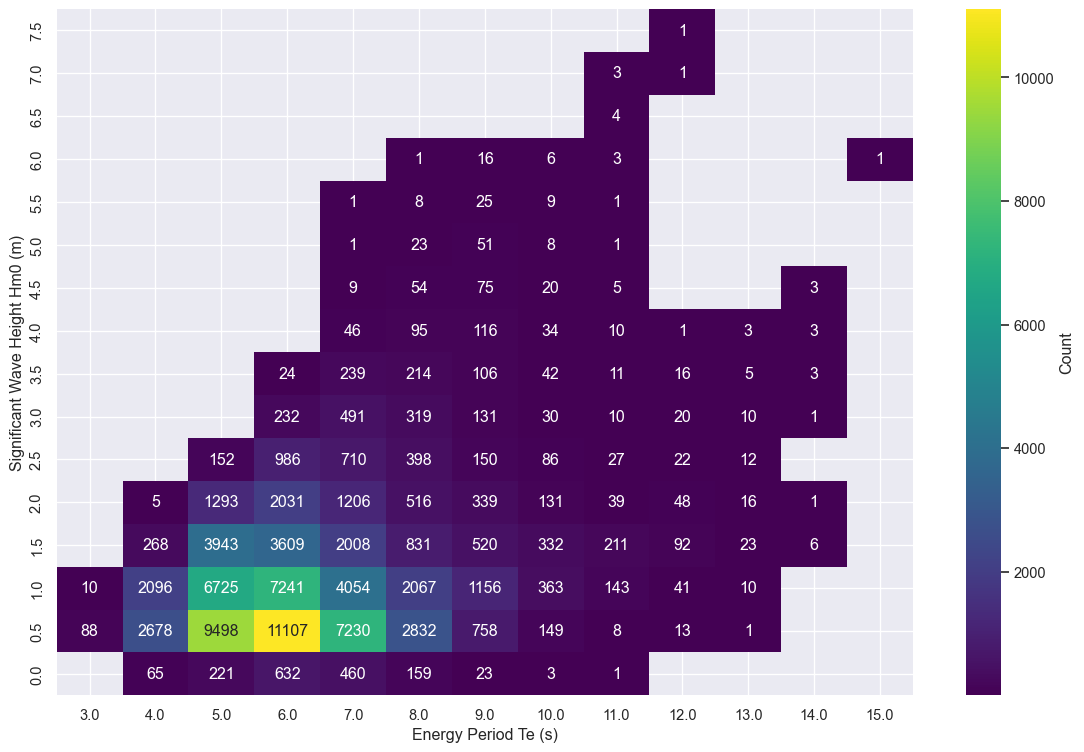
<figcaption>Figure 20: Distribution of Sea States at Nags Head (CDIP
243), Showing Occurrence Count of Combined Significant Wave Height
(<span
class="math inline"><em>H</em><sub><em>m</em><sub>0</sub></sub></span>)
and Energy Period (<span
class="math inline"><em>T</em><sub><em>e</em></sub></span>)
Conditions</figcaption>
</figure>

The sea state matrices reveal distinct wave climates at each location.
As shown in
<a href="#fig-wave-stats-225-count" class="quarto-xref">Figure 19</a>,
the WETS site exhibits wave heights predominantly below 5 m, with energy
periods clustered between 6-12 seconds. In contrast,
<a href="#fig-wave-stats-243-count" class="quarto-xref">Figure 20</a>
shows that Nags Head experiences a broader range of conditions, with
wave heights reaching 7.5 m and energy periods spanning 3-15 seconds.
The presence of 3-second periods at Nags Head likely indicates local
wind-generated waves, a characteristic absent at WETS.

These differing wave climate characteristics confirm that our dataset
captures a diverse range of sea states across both locations, providing
a robust foundation for model development. The comprehensive coverage of
wave conditions suggests we can proceed with creating training datasets
that will expose our models to the full spectrum of expected wave
behaviors.

# 3. Data Cleaning and Dataset Generation

## 3.1 Structured Sampling Method

Based on the sea state distributions shown in
<a href="#fig-wave-stats-225-count" class="quarto-xref">Figure 19</a>
and
<a href="#fig-wave-stats-243-count" class="quarto-xref">Figure 20</a>,
we developed a systematic sampling method to create balanced training
datasets. The approach, implemented in
<a href="#lst-bin-sampling" class="quarto-xref">Listing 4</a>, samples
time series segments from each combination of significant wave height
and energy period bins, ensuring representation across the full range of
observed wave conditions.

    def sample_wave_bins(df, n_samples=1, hm0_step=0.5, te_step=1.0):
        # Create bins for Hm0 and Te
        hm0_bins = np.arange(0, df['significant_wave_height_meters'].max() + hm0_step, hm0_step)
        te_bins = np.arange(0, df['energy_period_seconds'].max() + te_step, te_step)

        # Add bin columns to the dataframe
        df_binned = df.copy()
        df_binned['hm0_bin'] = pd.cut(df['significant_wave_height_meters'],
                                     bins=hm0_bins,
                                     labels=hm0_bins[:-1],
                                     include_lowest=True)

        df_binned['te_bin'] = pd.cut(df['energy_period_seconds'],
                                    bins=te_bins,
                                    labels=te_bins[:-1],
                                    include_lowest=True)

        # Convert category types to float
        df_binned['hm0_bin'] = df_binned['hm0_bin'].astype(float)
        df_binned['te_bin'] = df_binned['te_bin'].astype(float)

        # Sample from each bin combination
        samples = []
        for hm0_val in df_binned['hm0_bin'].unique():
            for te_val in df_binned['te_bin'].unique():
                bin_data = df_binned[
                    (df_binned['hm0_bin'] == hm0_val) &
                    (df_binned['te_bin'] == te_val)
                ]

                if not bin_data.empty:
                    # Sample min(n_samples, bin size) rows from this bin
                    bin_samples = bin_data.sample(
                        n=min(n_samples, len(bin_data)),
                        random_state=42  # For reproducibility
                    )
                    samples.append(bin_samples)

        # Combine all samples
        if samples:
            result = pd.concat(samples, axis=0).reset_index(drop=True)

            # Add bin center values for reference
            result['hm0_bin_center'] = result['hm0_bin'] + (hm0_step / 2)
            result['te_bin_center'] = result['te_bin'] + (te_step / 2)
            result.insert(0, 'station_number', result.pop('station_number'))


            return result
        else:
            return pd.DataFrame()

Listing 4: Function to Sample Sea State Matrix Bins

## 3.2 Training Dataset Creation

In [31]:
data_225 = sample_wave_bins(qoi_225)
data_225.to_parquet("../model_input_spec_225.parquet")

In [32]:
data_225.head()

In [33]:
data_225.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   station_number                    76 non-null     object 
 1   significant_wave_height_meters    76 non-null     float64
 2   energy_period_seconds             76 non-null     float64
 3   omnidirectional_wave_energy_flux  76 non-null     float64
 4   path                              76 non-null     object 
 5   hm0_bin                           76 non-null     float64
 6   te_bin                            76 non-null     float64
 7   hm0_bin_center                    76 non-null     float64
 8   te_bin_center                     76 non-null     float64
dtypes: float64(7), object(2)
memory usage: 5.5+ KB

In [34]:
data_243 = sample_wave_bins(qoi_243)
data_243.to_parquet("../model_input_spec_243.parquet")

In [35]:
data_243.head()

In [36]:
data_243.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   station_number                    112 non-null    object 
 1   significant_wave_height_meters    112 non-null    float64
 2   energy_period_seconds             112 non-null    float64
 3   omnidirectional_wave_energy_flux  112 non-null    float64
 4   path                              112 non-null    object 
 5   hm0_bin                           112 non-null    float64
 6   te_bin                            112 non-null    float64
 7   hm0_bin_center                    112 non-null    float64
 8   te_bin_center                     112 non-null    float64
dtypes: float64(7), object(2)
memory usage: 8.0+ KB

Initial sampling with one sample per bin yielded 76 half-hour segments
for WETS (CDIP 225) and 112 segments for Nags Head (CDIP 243), providing
a manageable dataset for initial model development. To explore the
impact of dataset size on model performance, we also created expanded
datasets with five samples per bin, resulting in 380 segments for WETS
and 560 segments for Nags Head. While these larger datasets offer more
comprehensive coverage of wave conditions, they require significantly
more computational resources for training.

This sampling approach ensures our training data captures the diverse
wave conditions present at each site while maintaining computational
feasibility. The structured nature of the sampling helps prevent bias
toward more common wave conditions, potentially improving model
robustness across different sea states.

In [37]:
n_samples = 5
data_225 = sample_wave_bins(qoi_225, n_samples=n_samples)
data_225.to_parquet(f"../model_input.samples_{n_samples}._spec_225.parquet")

data_243 = sample_wave_bins(qoi_243, n_samples=n_samples)
data_243.to_parquet(f"../model_input.samples_{n_samples}.spec_243.parquet")

In [38]:
print(len(data_225))

353

In [39]:
print(len(data_243))

493

Additional datasets with five samples per bin were also created (353
segments for WETS and 493 for Nags Head) and archived for future
research, though this project focuses on the more computationally
manageable single-sample datasets.

# 4. Deep Learning Models

Building on the architectural overview presented in
<a href="#sec-dl-overview" class="quarto-xref">Section 1.3</a>, we
implemented three neural network models using PyTorch Ansel et al.
(2024) to predict ocean wave displacements. Each model architecture was
chosen and designed to capture different aspects of the temporal
patterns present in wave motion.

## 4.1 LSTM Model

Our base LSTM model, shown in
<a href="#lst-lstm-model" class="quarto-xref">Listing 5</a>, provides a
straightforward approach to sequence prediction. The model processes
three-dimensional displacement inputs through stacked LSTM layers with
dropout regularization. This architecture enables the model to learn
wave patterns at different time scales. The final linear layer maps the
LSTM outputs back to displacement predictions, creating a direct
sequence-to-sequence prediction framework.

## 4.2 Enhanced LSTM Model

The enhanced LSTM implementation, detailed in
<a href="#lst-enh-lstm-model" class="quarto-xref">Listing 6</a>, extends
the base model with several architectural improvements. Bidirectional
processing allows the model to consider both past and future context
when making predictions. The addition of skip connections helps maintain
gradient flow through the deep network, while layer normalization
stabilizes training.

## 4.3 Transformer Model

Our Transformer implementation, shown in
<a href="#lst-trans-model" class="quarto-xref">Listing 7</a>, takes a
fundamentally different approach to sequence modeling. Rather than
processing the wave motion sequentially, the model uses self-attention
mechanisms to directly capture relationships between any two points in
the input sequence. This architecture, combined with multi-head
attention and position-wise feed-forward networks, should enable the
model to identify both short-term wave patterns and longer-range
dependencies in the displacement data.

# 5. Training

We implemented the model training process using PyTorch Lightning Falcon
and The PyTorch Lightning team (2019) to standardize the training,
validation, and testing procedures. The Mean Absolute Error was selected
as the loss function for evaluating prediction accuracy. Data was split
using an 80-20 train-test split, with the training portion further
divided 80-20 for validation.

All models were trained with consistent hyperparameters: learning rate
of 0.001, Adam optimizer, 128-sample input and prediction windows, and
128 hidden dimensions. Training data consisted of one 30-minute dataset
per sea state bin for each CDIP location. We tested several model
configurations, including baseline LSTM (25 epochs), extended LSTM (100
epochs), varying LSTM layer depths (4 and 6 layers), and both basic and
enhanced Transformer architectures. Model specifications are shown in
<a href="#tbl-model-arch" class="quarto-xref">Table 3</a>.

| Model Type | Layers | Epochs | Special Features |
|-------------------|--------------|--------------|--------------------------|
| Baseline LSTM | 2 | 25 | Basic implementation |
| Extended LSTM | 2 | 100 | Same as baseline with longer training |
| Deep LSTM | 4 | 25 | Additional LSTM layers |
| Deeper LSTM | 6 | 25 | Maximum layer depth tested |
| Enhanced LSTM | 2 | 25 | Bidirectional processing, skip connections, layer normalization |
| Basic Transformer | 2 | 25 | Multi-head attention mechanism |
| Enhanced Transformer | 2 | 25 | Additional positional encoding, enhanced feed-forward network |

Table 3: Model Architecture Specifications

The full training code can be found in this projects GitHub Repository
in the file `./train_window_from_spec.py`.

## 5.1 Training Metrics

### 5.1.1 Baseline Model

``` python
df = pd.read_parquet("../training_history/training_history_lstm_20241207_205254.parquet")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])
plt.show()

df = pd.read_parquet("../training_history/training_history_lstm_20241207_215544.parquet")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])
plt.show()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-225-train-baseline-1">
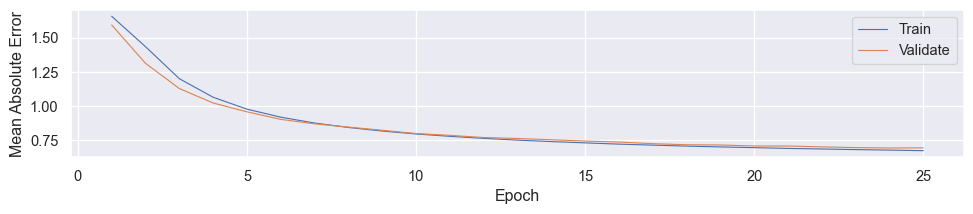
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-225-train-baseline-2">
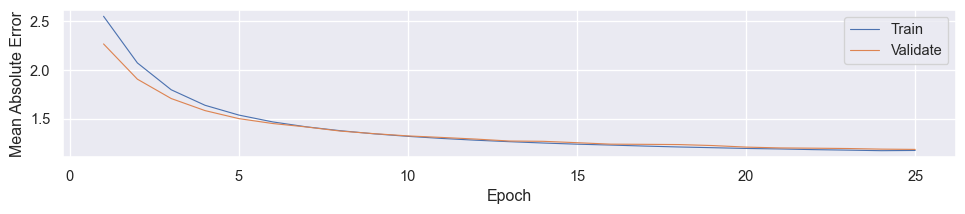
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 21: Baseline Model: Training vs. Validation Mean Absolute Error

### 5.1.2 100 Epoch LSTM Model

``` python
df = pd.read_parquet("../training_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_100/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])
plt.show()

df = pd.read_parquet("../training_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_100/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])
plt.show()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-225-train-100-lstm-1">
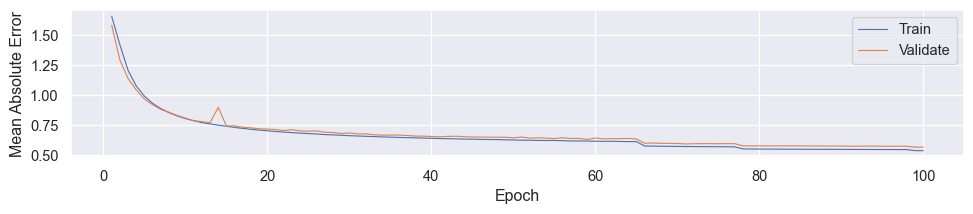
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-225-train-100-lstm-2">
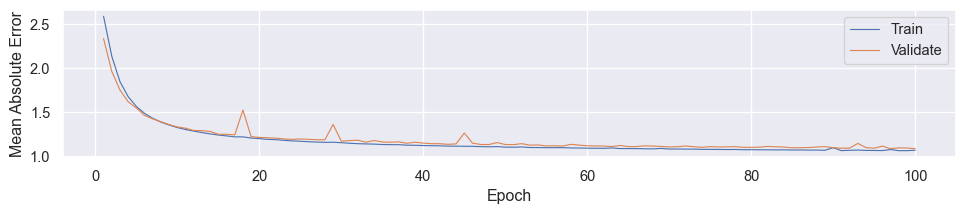
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 22: 100 Epoch LSTM Model: Training vs. Validation Mean Absolute
Error

### 5.1.3 Transformer Model

``` python
df = pd.read_parquet("../training_history/model_transformer.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])

plt.show()

df = pd.read_parquet("../training_history/model_transformer.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/")
df = df.set_index(['epoch'])
fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])

plt.show()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-225-train-transformer-1">
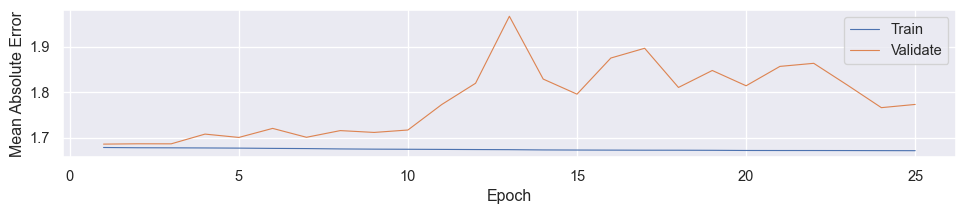
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-225-train-transformer-2">
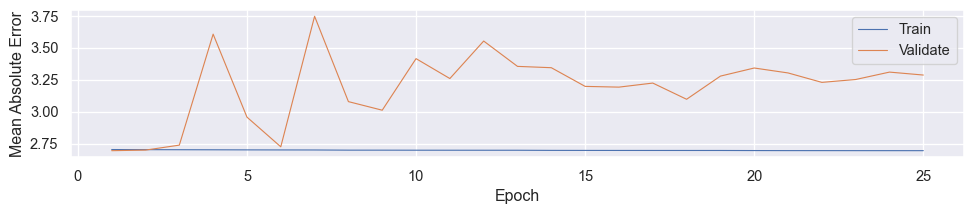
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 23: Transformer Model: Training vs. Validation Mean Absolute
Error

### 5.1.4 4 Layer LSTM Model

``` python
df = pd.read_parquet("../training_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_4.EPOCHS_25/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])
plt.show()

df = pd.read_parquet("../training_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_4.EPOCHS_25/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])
plt.show()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-train-4-layer-lstm-1">
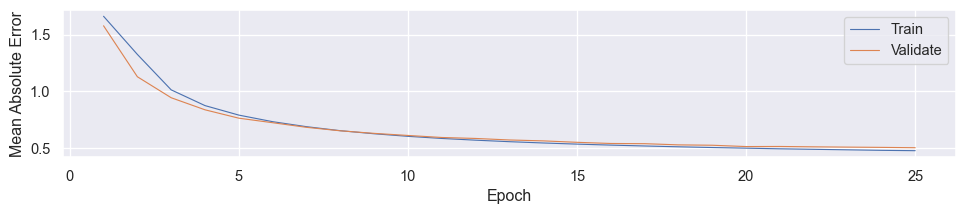
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-train-4-layer-lstm-2">
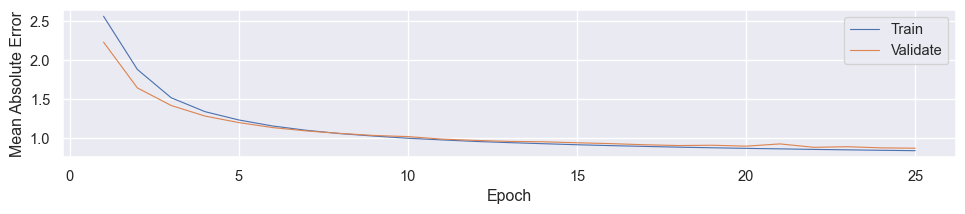
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 24: 4 Layer LSTM Model: Training vs. Validation Mean Absolute
Error

### 5.1.5 6 Layer LSTM Model

``` python
df = pd.read_parquet("../training_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_6.EPOCHS_25/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])

plt.show()

df = pd.read_parquet("../training_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_6.EPOCHS_25/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])
plt.show()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-train-6-layer-lstm-1">
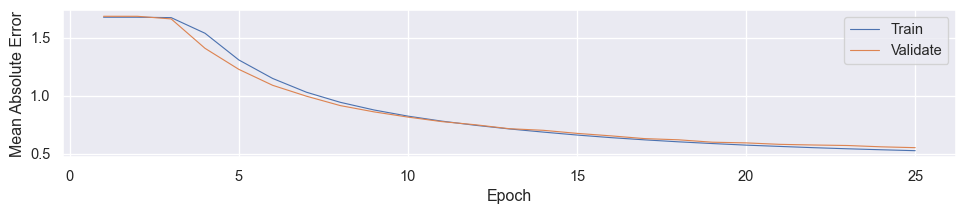
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-train-6-layer-lstm-2">
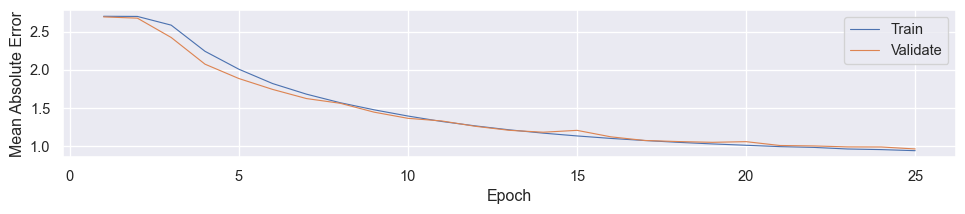
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 25: 6 Layer LSTM Model: Training vs. Validation Mean Absolute
Error

### 5.1.6 Enhanced Transformer Model

``` python
df = pd.read_parquet("../training_history/model_enhanced_transformer.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])

plt.show()

df = pd.read_parquet("../training_history/model_enhanced_transformer.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])
plt.show()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-train-enhanced-trans-1">
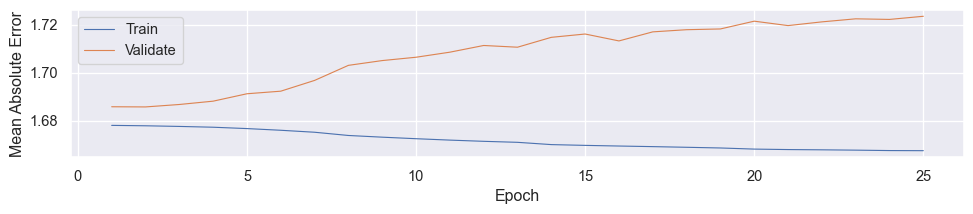
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-train-enhanced-trans-2">
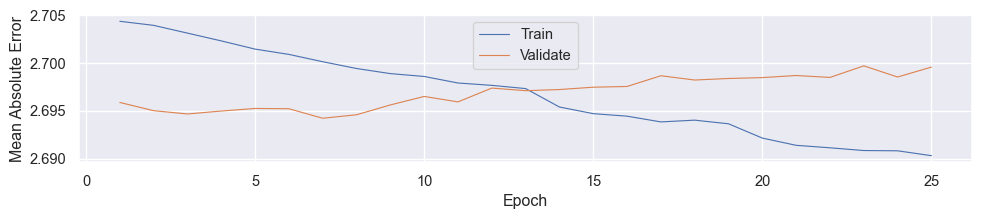
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 26: Enhanced Transformer Model: Training vs. Validation Mean
Absolute Error

### 5.1.7 Enhanced LSTM Model

``` python
df = pd.read_parquet("../training_history/model_enhanced_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])

plt.show()

df = pd.read_parquet("../training_history/model_enhanced_transformer.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/")
df = df.set_index(['epoch'])

fig, axs = plt.subplots(figsize=(12, 2))
df[['train_mae', 'val_mae']].plot(ax=axs, linewidth = 0.85, xlabel="Epoch", ylabel="Mean Absolute Error")
axs.legend(['Train', "Validate"])
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-train-enhanced-lstm-1">
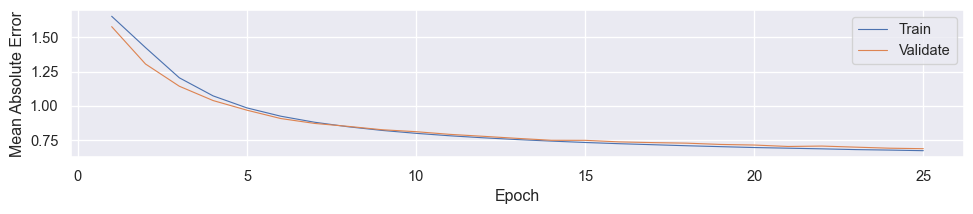
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-train-enhanced-lstm-2">
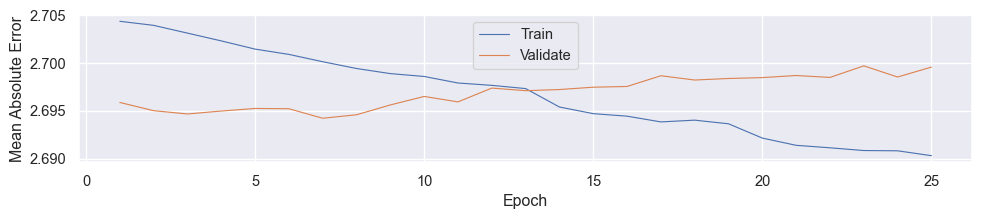
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 27: Enhanced LSTM Model: Training vs. Validation Mean Absolute
Error

## 5.2 Training Results Summary

The training results, shown in
<a href="#fig-225-train-baseline" class="quarto-xref">Figure 21</a>
through
<a href="#fig-train-enhanced-lstm" class="quarto-xref">Figure 27</a>,
indicate superior performance from the LSTM-based models. All LSTM
variants demonstrated stable learning curves without significant
overfitting. Notably, the 100-epoch LSTM model showed continued
improvement in both training and validation loss, suggesting potential
benefits from extended training periods. The Transformer models, while
marginally functional, generally showed poor learning patterns compared
to their LSTM counterparts.

# 6. Results

Model performance was evaluated using a test set comprising 20% of the
sampled data. Each model generated predictions using 128-sample input
windows, with results mapped back to the original time series for
comparison with measured displacements.

In [50]:
result_stats = []

In [51]:
from sklearn.metrics import mean_absolute_error, r2_score

def calc_stats(label, station, targets, predictions, column='vert_displacement_meters'):
    return {
        'label': label,
        'station': station,
        'mae': mean_absolute_error(targets[column], predictions[column]),
        'r2': r2_score(targets[column], predictions[column]),
        'correlation': np.corrcoef(targets[column], predictions[column])[0,1]
    }

In [52]:
def plot_test_section_compared_to_input(index, this_bins_df, this_source, this_targets, this_predictions, n_samples=128):
    # Calculate start and stop indices
    start = index * n_samples
    stop = start + n_samples

    # Get source path and load input data
    source_path = this_source.iloc[index]['Source Path']
    input_df = pd.read_parquet(source_path)

    # Get statistics for the title
    stats = this_bins_df[this_bins_df["path"] == source_path]

    # Create figure
    fig, ax = plt.subplots(figsize=(16, 3))

    # Create index arrays for proper alignment
    input_index = np.arange(n_samples * 2)
    shifted_index = np.arange(n_samples, 2 * n_samples)

    # Plot input data with original index
    ax.plot(input_index, input_df['vert_displacement_meters'].iloc[:n_samples * 2].values,
            linewidth=0.85, label="Input", alpha=0.7)

    # Plot target and prediction with shifted index
    ax.plot(shifted_index,
            this_targets['vert_displacement_meters'].iloc[start:stop].values,
            label="Target", linewidth=0.85)
    ax.plot(shifted_index,
            this_predictions['vert_displacement_meters'].iloc[start:stop].values,
            label="Prediction", linewidth=0.75)

    # Configure plot
    plt.ylabel("Vertical Displacement [m]")
    plt.legend(loc="upper right")
    plt.title(
        f"CDIP {stats['station_number'].item()} - $H_{{m0}}$: {stats['hm0_bin'].item()}, "
        f"$T_{{e}}$: {stats['te_bin'].item()}"
    )

    plt.tight_layout()
    plt.show()

def plot_test_section(index, this_bins_df, this_source, this_targets, this_predictions, n_samples=128):
    # Calculate start and stop indices
    start = index * n_samples
    stop = start + n_samples

    scale_factor = 0.5

    this_targets = this_targets.copy()
    this_predictions = this_predictions.copy()

    this_targets *= scale_factor
    this_predictions *= scale_factor

    # Get source path and load input data
    source_path = this_source.iloc[index]['Source Path']

    # Get statistics for the title
    stats = this_bins_df[this_bins_df["path"] == source_path]

    # Create figure
    fig, ax = plt.subplots(figsize=(16, 3))

    ax.plot(
            this_targets['vert_displacement_meters'].iloc[start:stop].values,
            label="Target", linewidth=0.85, marker=".", markersize=4)
    ax.plot(
            this_predictions['vert_displacement_meters'].iloc[start:stop].values,
            label="Prediction", linewidth=0.75, marker=".", markersize=4)

    # Configure plot
    plt.ylabel("Vertical Displacement [m]")
    plt.legend(loc="upper right")
    plt.title(
        f"CDIP {stats['station_number'].item()} - $H_{{m_0}}$: {stats['hm0_bin'].item()}, "
        f"$T_{{e}}$: {stats['te_bin'].item()}",
        fontsize=18,
    )

    plt.tight_layout()
    plt.show()

## 6.1 Select Visual Analysis

To examine model performance across different wave conditions, we
present a series of representative time series comparisons. Each figure
shows a 128-sample window of predictions alongside the corresponding
measured wave displacements, with varying combinations of significant
wave height ($H_{m_0}$) and energy period ($T_e$). These comparisons
provide insight into how the models handle different wave states and
reveal characteristic prediction patterns.

### 6.1.1 Baseline LSTM Timeseries

### 6.1.2 CDIP 225 - Kaneohe Bay, HI

``` python
df_bins = pd.read_parquet("./model_input_spec_225.parquet")
targets = pd.read_parquet("../testing_history/model_lstm.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.targets.lstm_20241207_205411.parquet")
predictions = pd.read_parquet("../testing_history/model_lstm.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.predictions.lstm_20241207_205411.parquet")
sources = pd.read_parquet("../testing_history/model_lstm.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.sources.lstm_20241207_205411.parquet")

result_stats.append(calc_stats("Baseline", "225", targets, predictions))
```

``` python
plot_test_section(0, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-1">
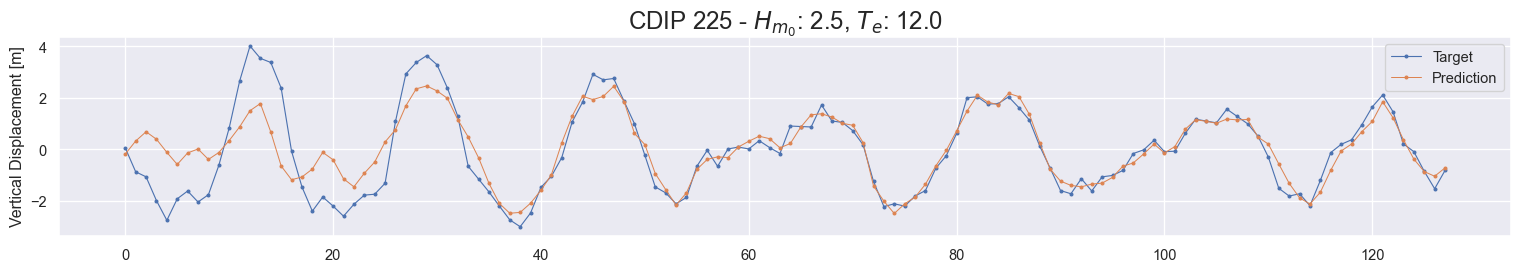
<figcaption>Figure 28: Baseline LSTM - CDIP 225 - Test Section
1</figcaption>
</figure>

``` python
plot_test_section(1, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-2">
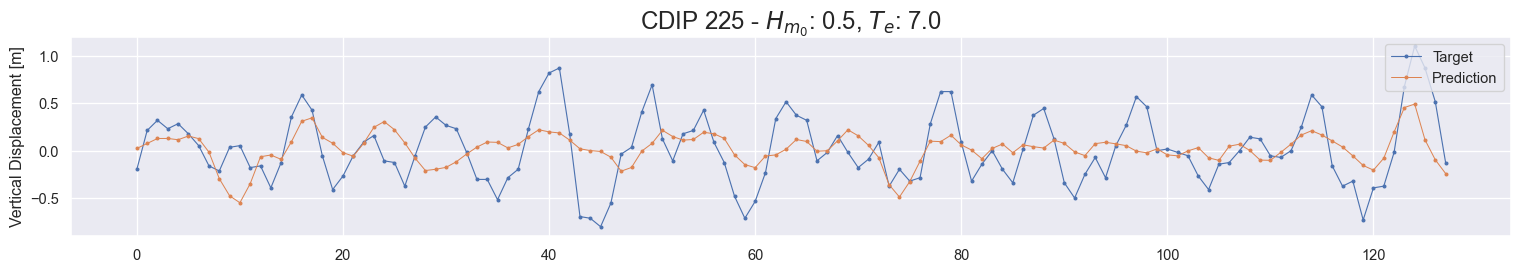
<figcaption>Figure 29: Baseline LSTM - CDIP 225 - Test Section
2</figcaption>
</figure>

``` python
plot_test_section(2, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-3">
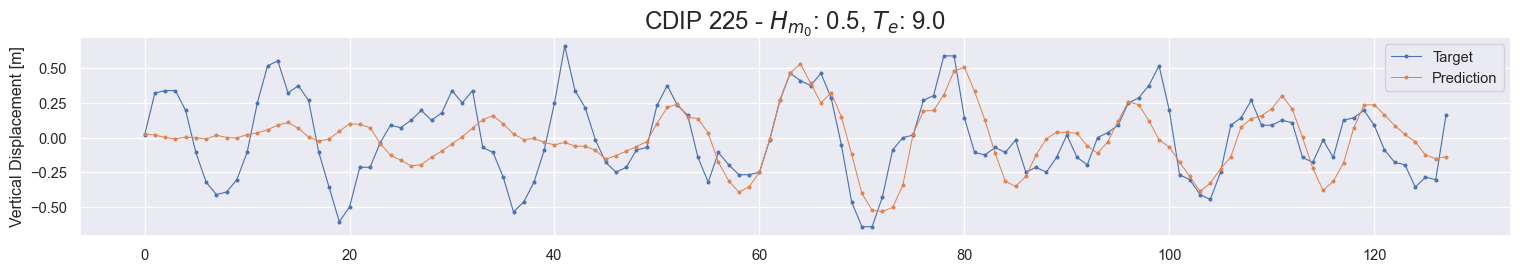
<figcaption>Figure 30: Baseline LSTM - CDIP 225 - Test Section
3</figcaption>
</figure>

``` python
plot_test_section(3, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-4">
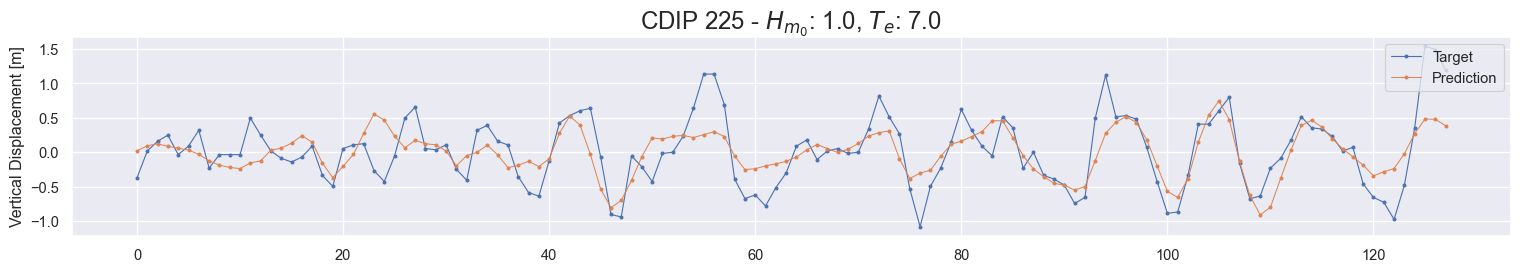
<figcaption>Figure 31: Baseline LSTM - CDIP 225 - Test Section
4</figcaption>
</figure>

``` python
plot_test_section(4, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-5">
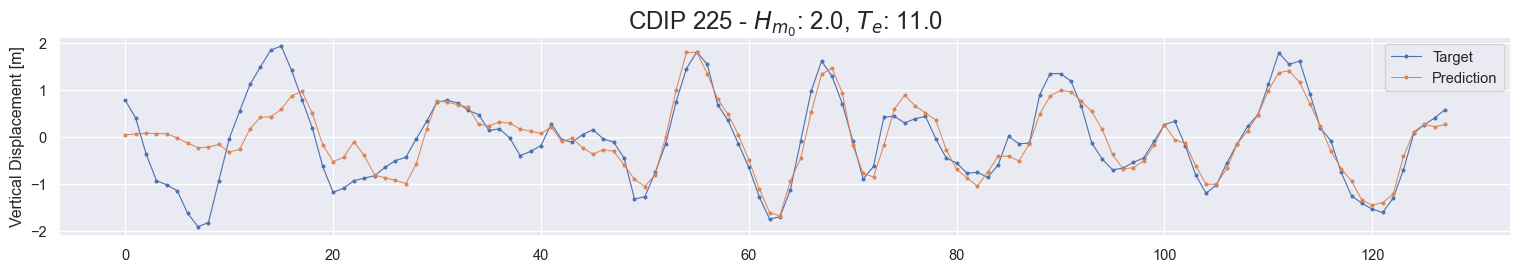
<figcaption>Figure 32: Baseline LSTM - CDIP 225 - Test Section
5</figcaption>
</figure>

``` python
plot_test_section(5, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-6">
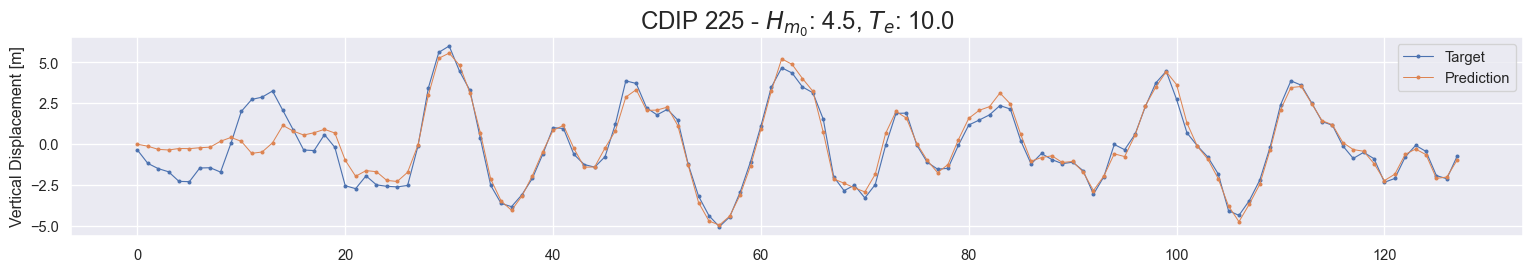
<figcaption>Figure 33: Baseline LSTM - CDIP 225 - Test Section
6</figcaption>
</figure>

### 6.1.3 CDIP 243 - Nags Head, NC

``` python
targets = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.targets.lstm_20241207_215743.parquet")
predictions = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.predictions.lstm_20241207_215743.parquet")
sources = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.sources.lstm_20241207_215743.parquet")
df_bins = pd.read_parquet("./model_input_spec_243.parquet")

result_stats.append(calc_stats("Baseline", "243", targets, predictions))
```

``` python
plot_test_section(0, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-1-nags">
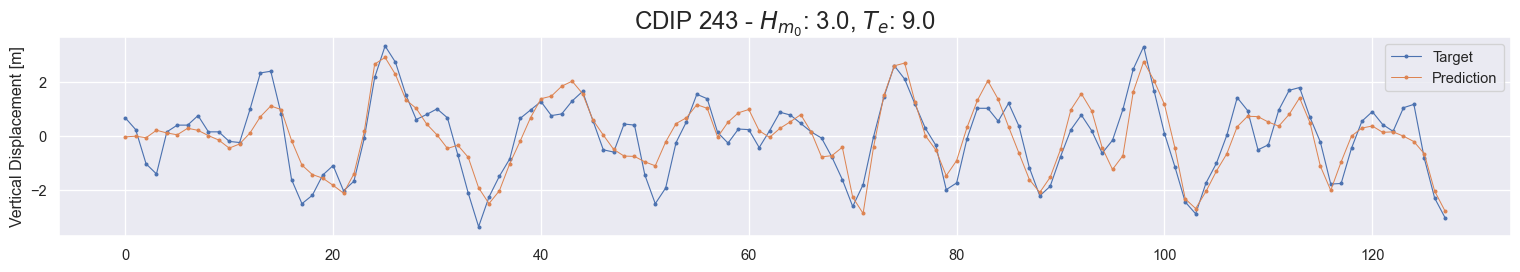
<figcaption>Figure 34: Baseline LSTM - CDIP 243 - Test Section
1</figcaption>
</figure>

``` python
plot_test_section(1, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-2-nags">
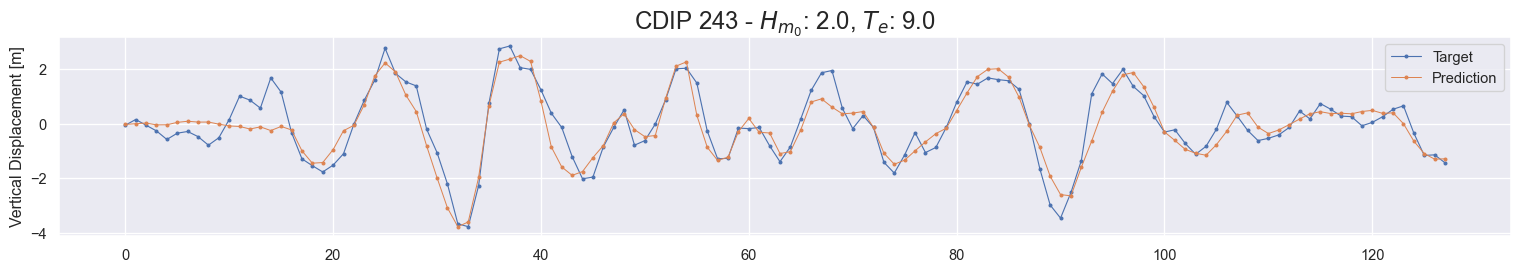
<figcaption>Figure 35: Baseline LSTM - CDIP 243 - Test Section
2</figcaption>
</figure>

``` python
plot_test_section(2, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-3-nags">
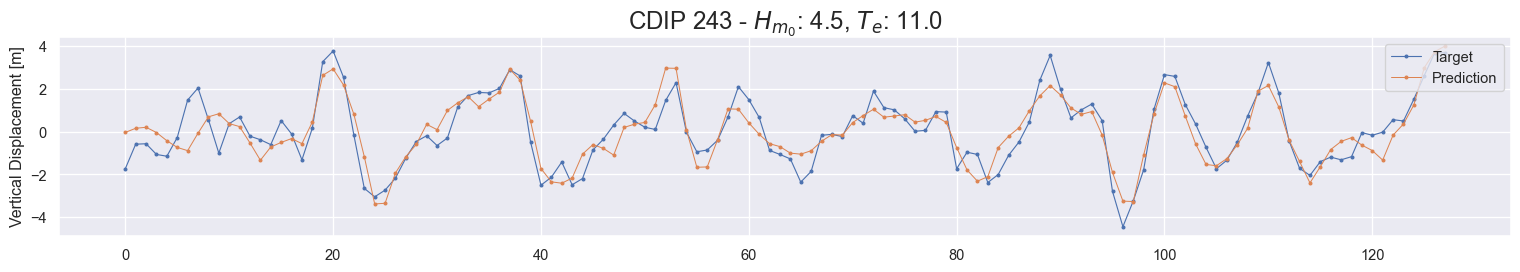
<figcaption>Figure 36: Baseline LSTM - CDIP 243 - Test Section
3</figcaption>
</figure>

``` python
plot_test_section(3, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-4-nags">
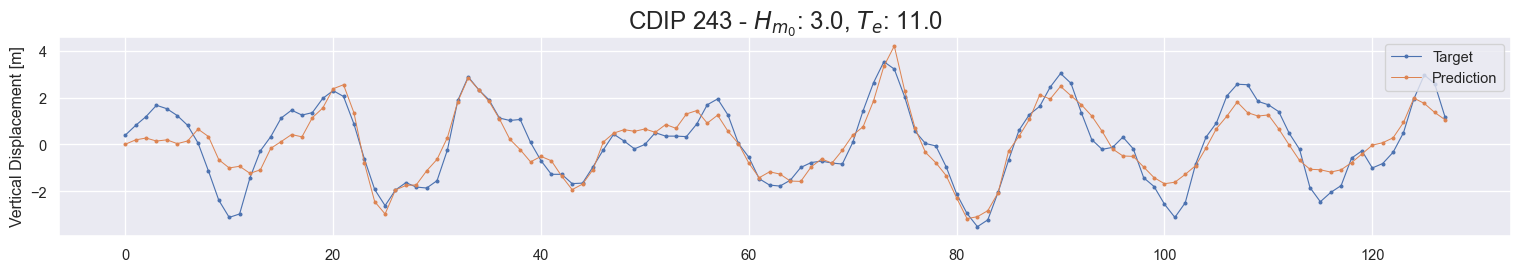
<figcaption>Figure 37: Baseline LSTM - CDIP 243 - Test Section
4</figcaption>
</figure>

``` python
plot_test_section(4, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-5-nags">
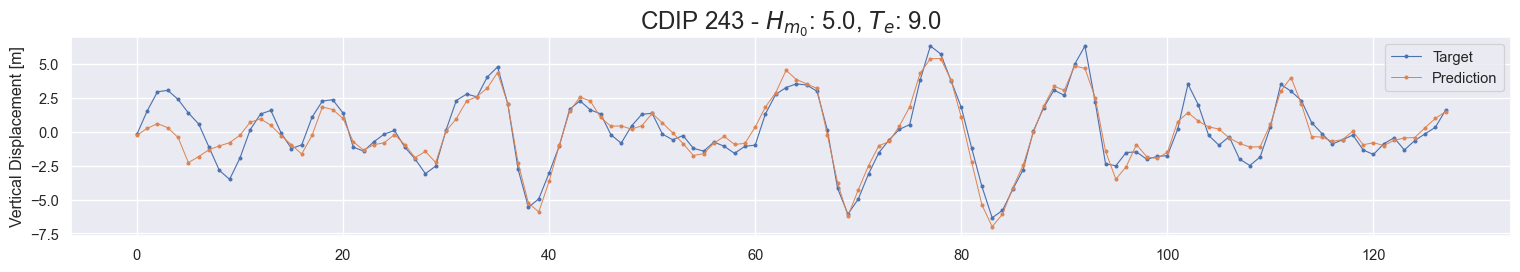
<figcaption>Figure 38: Baseline LSTM - CDIP 243 - Test Section
5</figcaption>
</figure>

``` python
plot_test_section(5, df_bins, sources, targets, predictions)
```

<figure id="fig-lstm-baseline-test-section-6-nags">
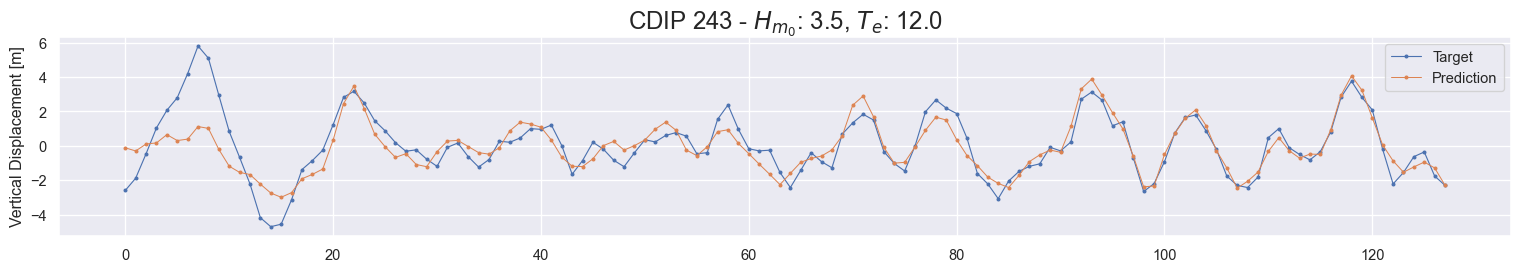
<figcaption>Figure 39: Baseline LSTM - CDIP 243 - Test Section
6</figcaption>
</figure>

The time series comparisons, shown in
<a href="#fig-lstm-baseline-test-section-1"
class="quarto-xref">Figure 28</a> through
<a href="#fig-lstm-baseline-test-section-6-nags"
class="quarto-xref">Figure 39</a>, reveal varying prediction quality
across different wave conditions. A common pattern emerges where
predictions show larger errors at the start of each sequence but improve
towards the end. This behavior suggests the models require several time
steps to establish the wave state context before making accurate
predictions. The LSTM models in particular demonstrate this adaptation,
likely due to their ability to build and refine internal state
representations as they process the sequence. Overall, the baseline
model demonstrates capacity to capture underlying wave patterns, though
prediction accuracy varies with wave state conditions.

## 6.2 Quantitive Visualization

### 6.2.1 Baseline Model

``` python
targets = pd.read_parquet("../testing_history/model_lstm.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.targets.lstm_20241207_205411.parquet")
predictions = pd.read_parquet("../testing_history/model_lstm.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.predictions.lstm_20241207_205411.parquet")
sources = pd.read_parquet("../testing_history/model_lstm.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.sources.lstm_20241207_205411.parquet")
df_bins = pd.read_parquet("./model_input_spec_225.parquet")

targets *= 0.3
predictions *= 0.3


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.legend(labels=["Train", "Test"])
plt.show()

targets = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.targets.lstm_20241207_215743.parquet")
predictions = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.predictions.lstm_20241207_215743.parquet")
sources = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.sources.lstm_20241207_215743.parquet")
df_bins = pd.read_parquet("./model_input_spec_243.parquet")

targets *= 0.3
predictions *= 0.3


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.legend(labels=["Train", "Test"])
plt.show()
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-lstm-baseline-test-all-1">
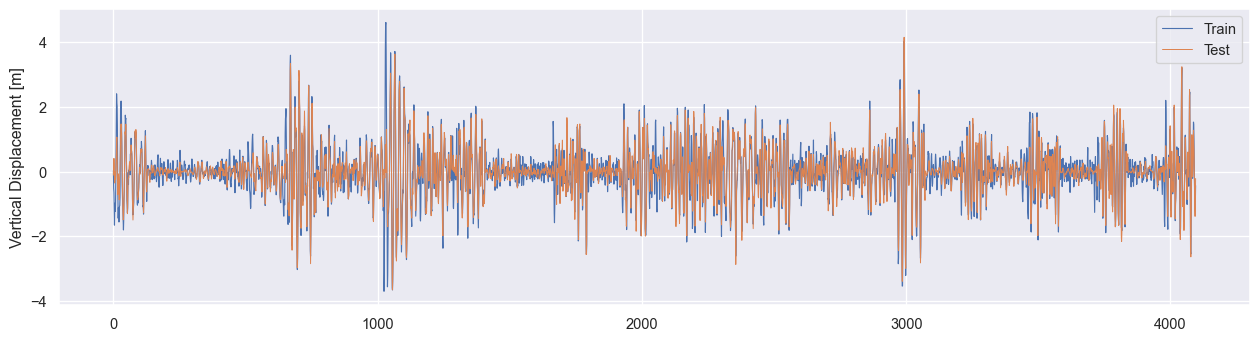
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-lstm-baseline-test-all-2">
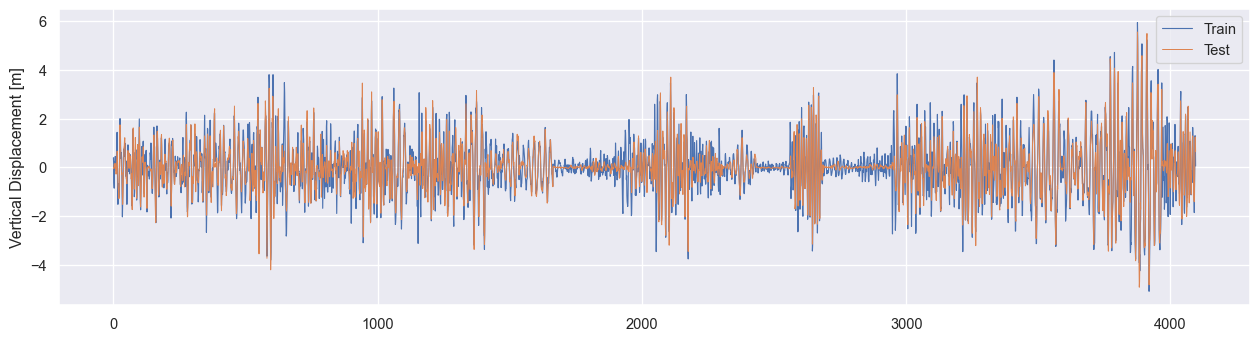
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 40: Baseline LSTM - All Test Sections

### 6.2.2 Transformer Model

``` python
targets = pd.read_parquet("../testing_history/model_transformer.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.targets.transformer_20241207_231033.parquet")
predictions = pd.read_parquet("../testing_history/model_transformer.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.predictions.transformer_20241207_231033.parquet")
sources = pd.read_parquet("../testing_history/model_transformer.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.sources.transformer_20241207_231033.parquet")

df_bins = pd.read_parquet("./model_input_spec_225.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()
result_stats.append(calc_stats("Transformer", "225", targets, predictions))

targets = pd.read_parquet("../testing_history/model_transformer.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.targets.transformer_20241207_235408.parquet")
predictions = pd.read_parquet("../testing_history/model_transformer.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.predictions.transformer_20241207_235408.parquet")
sources = pd.read_parquet("../testing_history/model_transformer.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.sources.transformer_20241207_235408.parquet")

df_bins = pd.read_parquet("./model_input_spec_243.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()

result_stats.append(calc_stats("Transformer", "243", targets, predictions))
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-transformer-test-all-1">
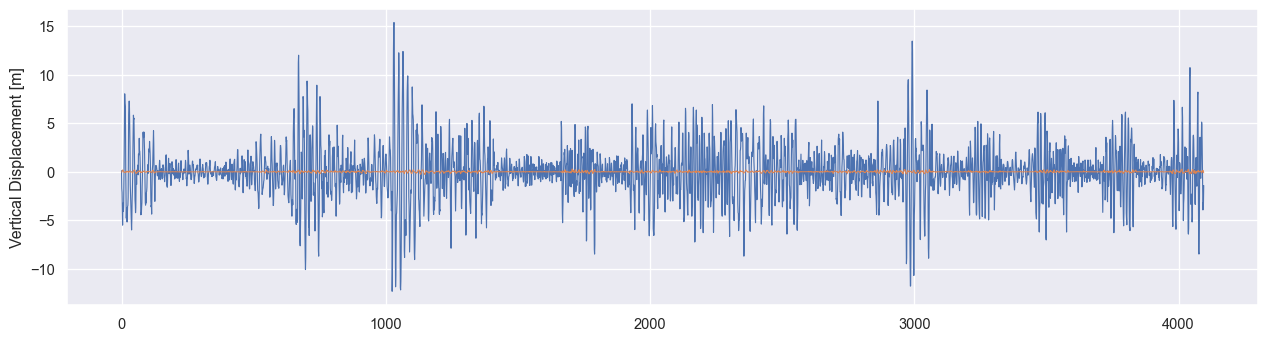
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-transformer-test-all-2">
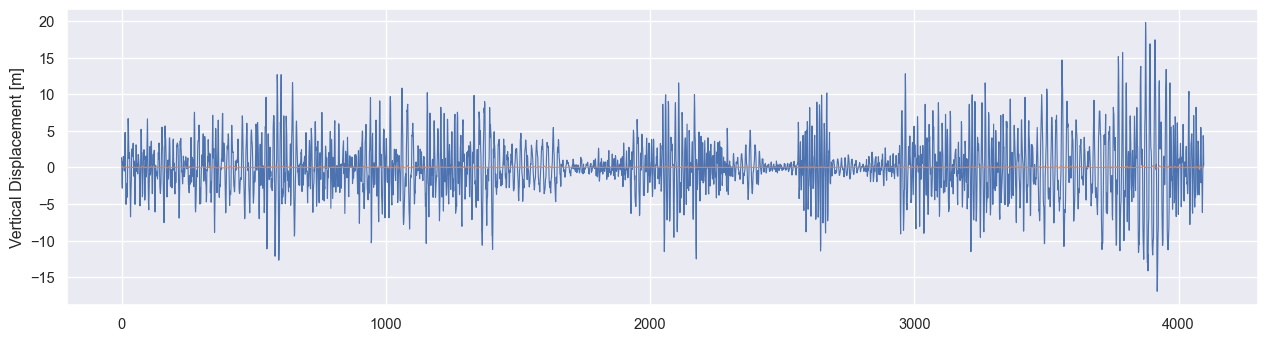
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 41: Transformer - All Test Sections

### 6.2.3 LSTM 100 Epoch Model

``` python
targets = pd.read_parquet("../testing_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_100/test_results.targets.lstm_20241208_023701.parquet")
predictions = pd.read_parquet("../testing_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_100/test_results.predictions.lstm_20241208_023701.parquet")
sources = pd.read_parquet("../testing_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_100/test_results.sources.lstm_20241208_023701.parquet")

df_bins = pd.read_parquet("./model_input_spec_225.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()
result_stats.append(calc_stats("100 Epoch LSTM", "225", targets, predictions))

targets = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_100/test_results.targets.lstm_20241208_061107.parquet")
predictions = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_100/test_results.predictions.lstm_20241208_061107.parquet")
sources = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_100/test_results.sources.lstm_20241208_061107.parquet")

df_bins = pd.read_parquet("./model_input_spec_243.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()
result_stats.append(calc_stats("100 Epoch LSTM", "243", targets, predictions))
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-transformer-lstm-100-1">
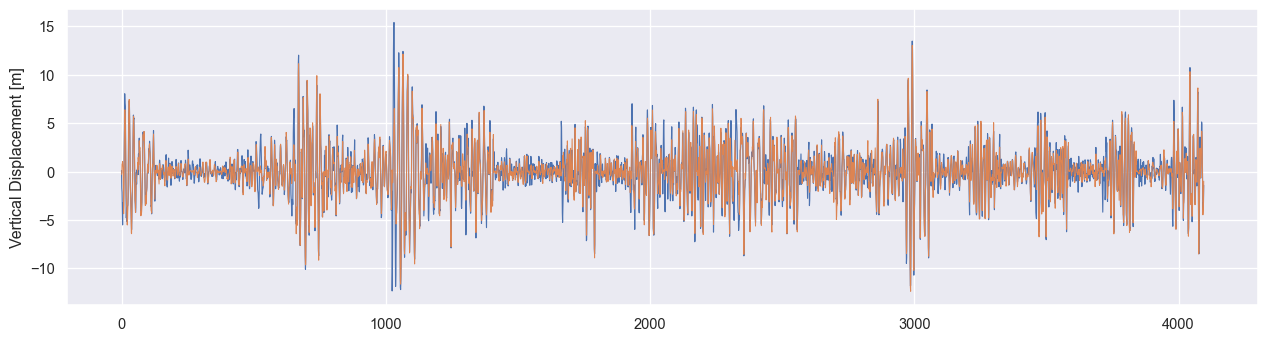
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-transformer-lstm-100-2">
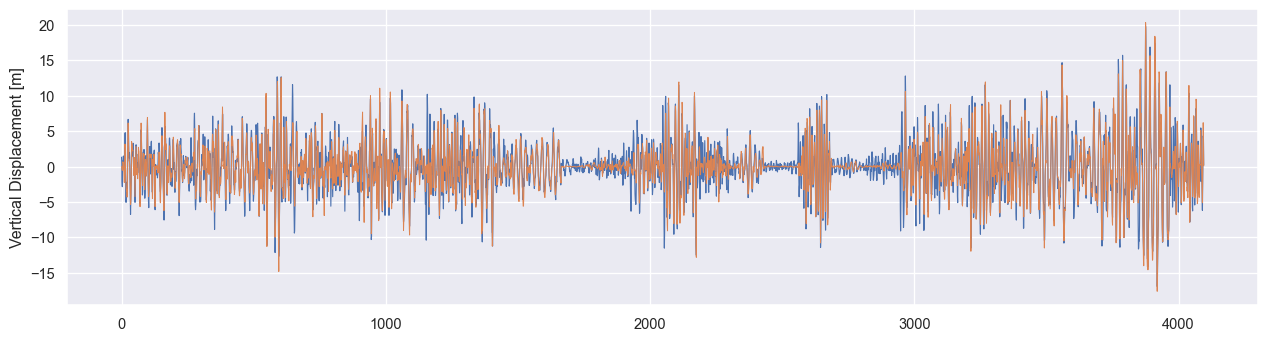
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 42: LSTM 100 Epoch - All Test Sections

### 6.2.4 LSTM 4 layers

``` python
targets = pd.read_parquet("../testing_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_4.EPOCHS_25/test_results.targets.lstm_20241208_072749.parquet")
predictions = pd.read_parquet("../testing_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_4.EPOCHS_25/test_results.predictions.lstm_20241208_072749.parquet")
sources = pd.read_parquet("../testing_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_4.EPOCHS_25/test_results.sources.lstm_20241208_072749.parquet")

df_bins = pd.read_parquet("./model_input_spec_225.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()
result_stats.append(calc_stats("4 Layer LSTM", "225", targets, predictions))

targets = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_4.EPOCHS_25/test_results.targets.lstm_20241208_083208.parquet")
predictions = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_4.EPOCHS_25/test_results.predictions.lstm_20241208_083208.parquet")
sources = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_4.EPOCHS_25/test_results.sources.lstm_20241208_083208.parquet")

df_bins = pd.read_parquet("./model_input_spec_243.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()
result_stats.append(calc_stats("4 Layer LSTM", "243", targets, predictions))
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-transformer-lstm-4-layer-1">
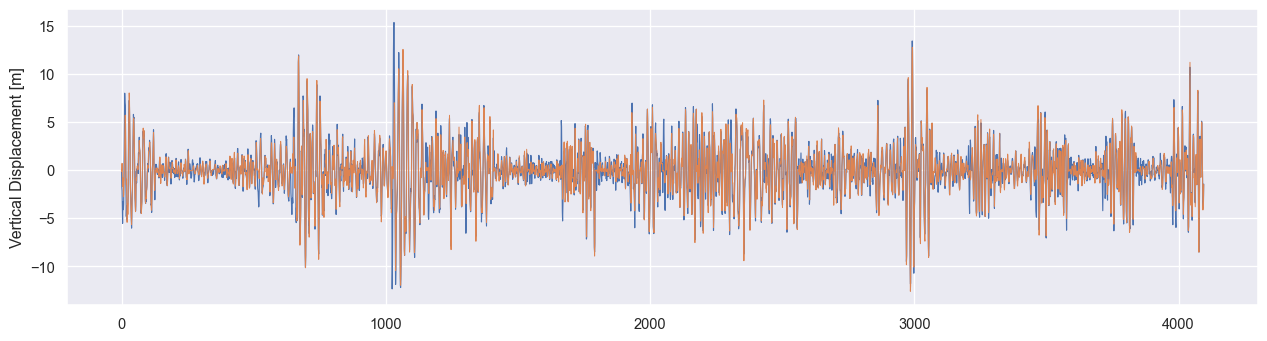
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-transformer-lstm-4-layer-2">
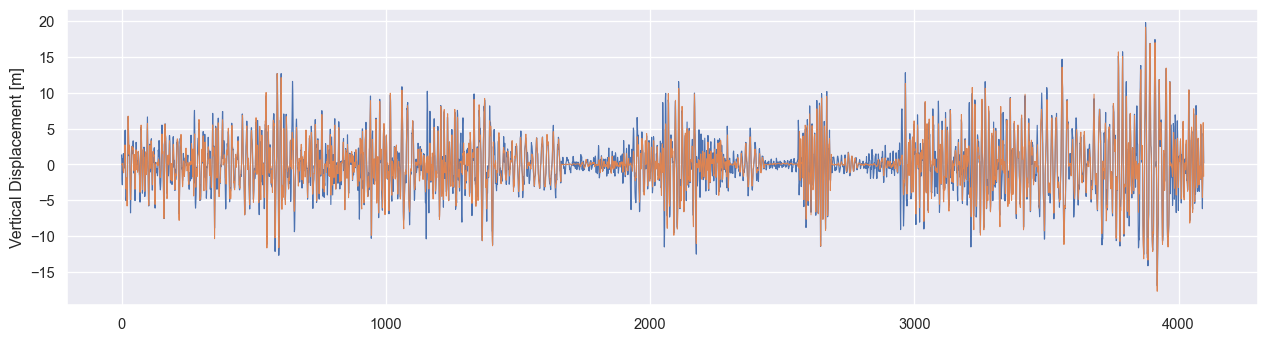
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 43: LSTM 4 Layer - All Test Sections

### 6.2.5 LSTM 6 Layer

``` python
targets = pd.read_parquet("../testing_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_6.EPOCHS_25/test_results.targets.lstm_20241208_093344.parquet")
predictions = pd.read_parquet("../testing_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_6.EPOCHS_25/test_results.predictions.lstm_20241208_093344.parquet")
sources = pd.read_parquet("../testing_history/model_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_6.EPOCHS_25/test_results.sources.lstm_20241208_093344.parquet")

df_bins = pd.read_parquet("./model_input_spec_225.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()

result_stats.append(calc_stats("6 Layer LSTM", "225", targets, predictions))

targets = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_6.EPOCHS_25/test_results.targets.lstm_20241208_110346.parquet")
predictions = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_6.EPOCHS_25/test_results.predictions.lstm_20241208_110346.parquet")
sources = pd.read_parquet("../testing_history/model_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_6.EPOCHS_25/test_results.sources.lstm_20241208_110346.parquet")

df_bins = pd.read_parquet("./model_input_spec_243.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()
result_stats.append(calc_stats("6 Layer LSTM", "243", targets, predictions))
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-transformer-lstm-6-layer-1">
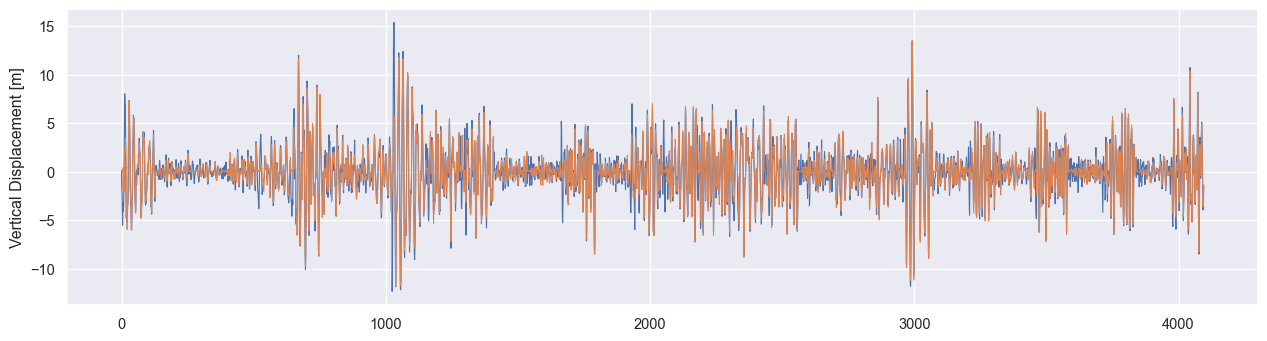
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-transformer-lstm-6-layer-2">
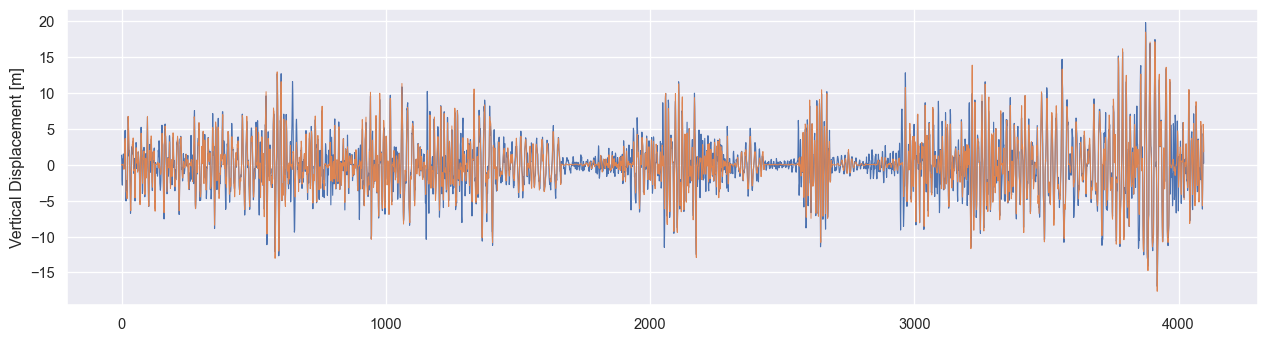
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 44: LSTM 6 Layer - All Test Sections

### 6.2.6 Enhanced Transformer

``` python
targets = pd.read_parquet("../testing_history/model_enhanced_transformer.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.targets.enhanced_transformer_20241208_121422.parquet")
predictions = pd.read_parquet("../testing_history/model_enhanced_transformer.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.predictions.enhanced_transformer_20241208_121422.parquet")
sources = pd.read_parquet("../testing_history/model_enhanced_transformer.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.sources.enhanced_transformer_20241208_121422.parquet")

df_bins = pd.read_parquet("./model_input_spec_225.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()

result_stats.append(calc_stats("Enhanced Transformer", "225", targets, predictions))

targets = pd.read_parquet("../testing_history/model_enhanced_transformer.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.targets.enhanced_transformer_20241208_125950.parquet")
predictions = pd.read_parquet("../testing_history/model_enhanced_transformer.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.predictions.enhanced_transformer_20241208_125950.parquet")
sources = pd.read_parquet("../testing_history/model_enhanced_transformer.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.sources.enhanced_transformer_20241208_125950.parquet")

df_bins = pd.read_parquet("./model_input_spec_243.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()
result_stats.append(calc_stats("Enhanced Transformer", "243", targets, predictions))
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-enhc-transformer-1">
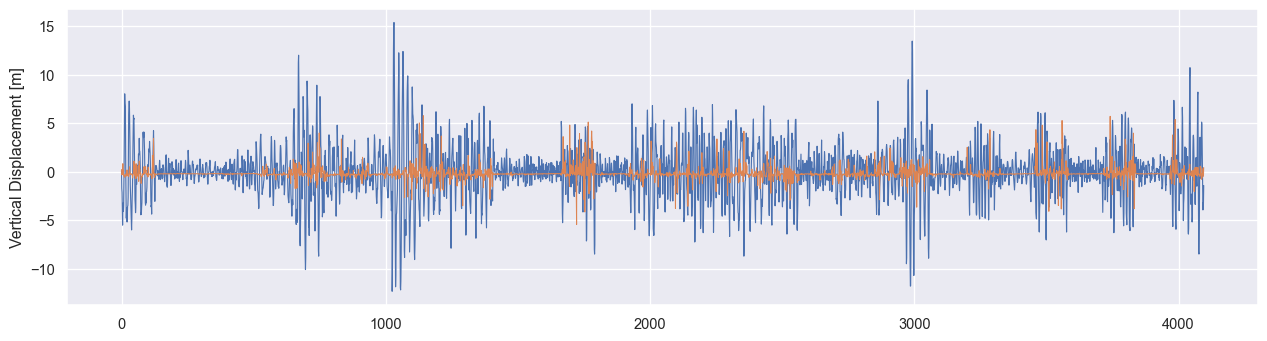
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-enhc-transformer-2">
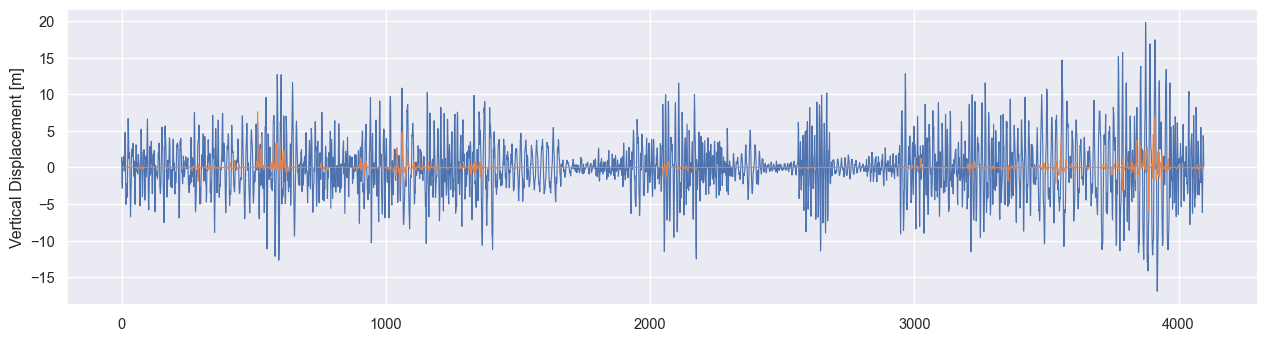
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 45: Enhanced Transformer - All Test Sections

### 6.2.7 Enhanced LSTM

``` python
targets = pd.read_parquet("../testing_history/model_enhanced_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.targets.enhanced_lstm_20241208_160252.parquet")
predictions = pd.read_parquet("../testing_history/model_enhanced_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.predictions.enhanced_lstm_20241208_160252.parquet")
sources = pd.read_parquet("../testing_history/model_enhanced_lstm.station_number_225.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.sources.enhanced_lstm_20241208_160252.parquet")

df_bins = pd.read_parquet("./model_input_spec_225.parquet")


# start = 128
start = 0
# end = start + 128
end = -1

targets['vert_displacement_meters'].iloc[start:end].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].iloc[start:end].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()

result_stats.append(calc_stats("Enhanced LSTM", "225", targets, predictions))

targets = pd.read_parquet("../testing_history/model_enhanced_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.targets.enhanced_lstm_20241208_170202.parquet")
predictions = pd.read_parquet("../testing_history/model_enhanced_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.predictions.enhanced_lstm_20241208_170202.parquet")
sources = pd.read_parquet("../testing_history/model_enhanced_lstm.station_number_243.window_128.hidden_dim_128.NUM_LAYERS_2.EPOCHS_25/test_results.sources.enhanced_lstm_20241208_170202.parquet")

df_bins = pd.read_parquet("./model_input_spec_243.parquet")


targets['vert_displacement_meters'].plot(figsize=(16, 4), label="target", linewidth = 0.85)
predictions['vert_displacement_meters'].plot(label="prediction", linewidth=0.75)
plt.ylabel("Vertical Displacement [m]")
plt.show()
result_stats.append(calc_stats("Enhanced LSTM", "243", targets, predictions))
```

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-enhc-lstm-1">
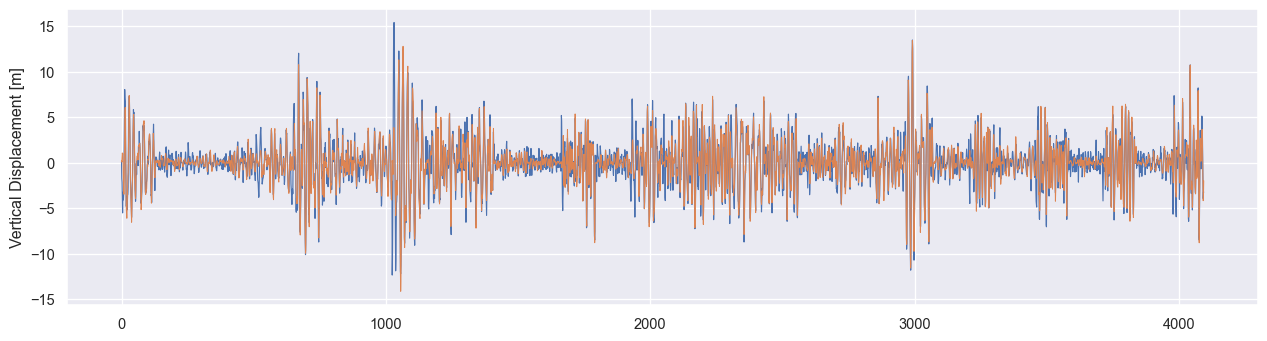
<figcaption>(a) CDIP 225</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<tbody>
<tr>
<td style="text-align: left;"><div
class="cell-output cell-output-display" width="100.0%"
data-layout-align="left">
<figure id="fig-enhc-lstm-2">
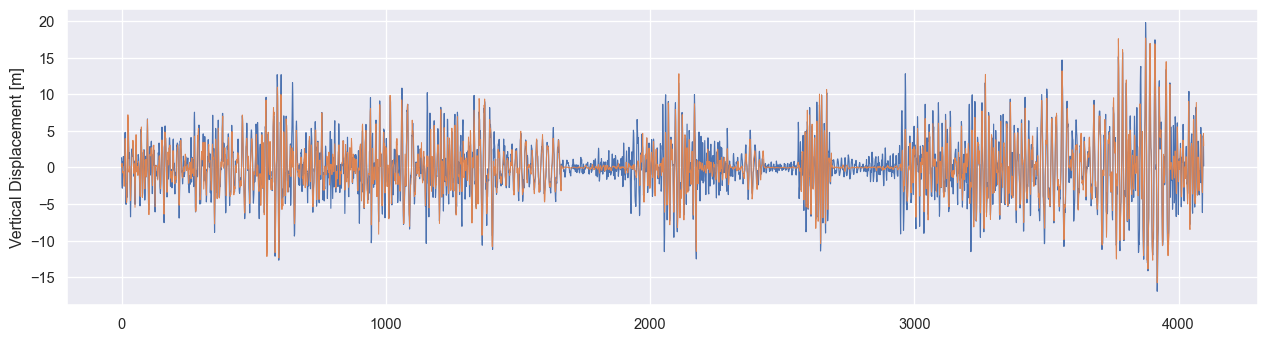
<figcaption>(b) CDIP 243</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 46: Enhanced LSTM - All Test Sections

<a href="#fig-lstm-baseline-test-all" class="quarto-xref">Figure 40</a>
through <a href="#fig-enhc-lstm" class="quarto-xref">Figure 46</a>
present the complete test set predictions against measured
displacements, offering a comprehensive view of model performance across
all wave conditions. The LSTM-based architectures demonstrate strong
predictive capabilities, closely tracking the measured wave
displacements across varying sea states. In particular, the baseline,
enhanced, 4-layer, and 6-layer LSTM models show consistent prediction
accuracy, suggesting successful learning of the underlying wave dynamics
across diverse conditions.

The visual alignment between predictions and measurements for the LSTM
models indicates their ability to capture both the frequency and
amplitude characteristics of the wave motion. This comprehensive fit
across different wave conditions supports the quantitative metrics and
demonstrates the models’ generalization capabilities. In contrast, the
Transformer models show notable deviation from the measured
displacements, confirming their limited effectiveness for this
prediction task.

## 6.3 Results Comparison

We evaluated model performance using three metrics: Mean Absolute Error
(MAE), coefficient of determination ($R^2$), and Pearson’s correlation
coefficient ($\rho$).

In [74]:
results_df = pd.DataFrame(result_stats)

### 6.3.1 Mean Absolute Error

In [75]:
results_df = results_df.sort_values(["mae", "station"])

plt.figure(figsize=(6, 3.5))
sns.barplot(results_df, y="label", x="mae", hue="station")
for i in plt.gca().containers:
    plt.bar_label(i, fmt='%.2f', padding=3)
plt.ylabel(None);
plt.xlabel("Mean Absolute Error");

``` python
plt.figure(figsize=(8, 4.0))
sns.barplot(results_df, y="station", x="mae", hue="label")
for i in plt.gca().containers:
    plt.bar_label(i, fmt='%.2f', padding=3)
plt.ylabel(None);
plt.xlabel("Mean Absolute Error");
plt.legend(bbox_to_anchor=(1.25, 1.0),
          loc='upper center',
          ncol=1,
          frameon=False, title="Model")
```

<figure id="fig-results-mae-comparison-by-station">
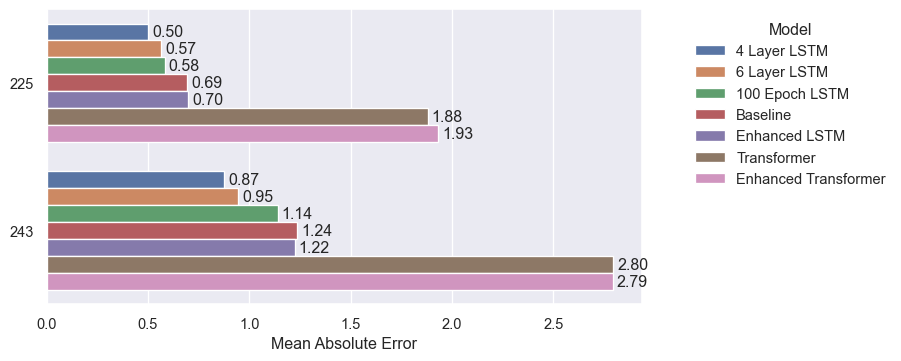
<figcaption>Figure 48: Mean Absolute Error Comparison by Station (Lower
is better)</figcaption>
</figure>

### 6.3.2 Coefficient of Determination, $R^2$

In [77]:
results_df = results_df.sort_values(["r2"], ascending=False)

plt.figure(figsize=(6, 3.5))
sns.barplot(results_df, y="label", x="r2", hue="station")
for i in plt.gca().containers:
    plt.bar_label(i, fmt='%.2f', padding=3)
plt.ylabel(None);
plt.xlabel("$R^2$");

``` python
plt.figure(figsize=(8, 4.0))
sns.barplot(results_df, y="station", x="r2", hue="label")
for i in plt.gca().containers:
    plt.bar_label(i, fmt='%.2f', padding=3)
plt.ylabel(None);
plt.xlabel("$R^2$");
plt.legend(bbox_to_anchor=(1.25, 1.0),
          loc='upper center',
          ncol=1,
          frameon=False, title="Model")
```

<figure id="fig-results-r2-comparison-by-station">
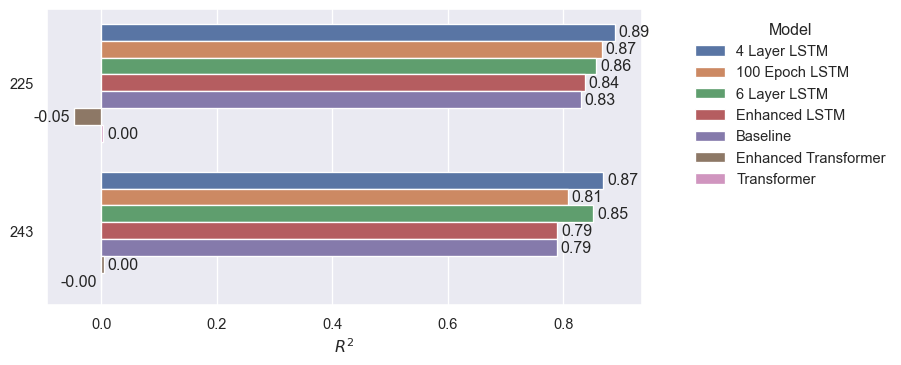
<figcaption>Figure 50: <span
class="math inline"><em>R</em><sup>2</sup></span> Comparison by
Station</figcaption>
</figure>

### 6.3.3 Pearson’s Correlation \[$\rho$\]

In [79]:
results_df = results_df.sort_values(["correlation"], ascending=False)

plt.figure(figsize=(6, 3.5))
sns.barplot(results_df, y="label", x="correlation", hue="station")
for i in plt.gca().containers:
    plt.bar_label(i, fmt='%.2f', padding=3)
plt.ylabel(None);
plt.xlabel("Correlation");

``` python
plt.figure(figsize=(8, 4.0))
sns.barplot(results_df, y="station", x="correlation", hue="label")
for i in plt.gca().containers:
    plt.bar_label(i, fmt='%.2f', padding=3)
plt.ylabel(None);
plt.xlabel("Correlation");
plt.legend(bbox_to_anchor=(1.25, 1.0),
          loc='upper center',
          ncol=1,
          frameon=False, title="Model")
```

<figure id="fig-results-correlation-comparison-by-station">
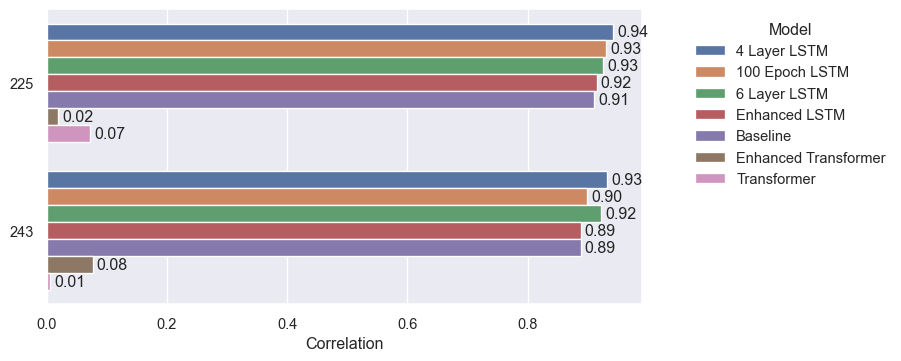
<figcaption>Figure 52: Pearson’s Correlation Comparison by
Station</figcaption>
</figure>

In [81]:
results_df

## 6.4 Results Summary

We evaluated model performance using three metrics: Mean Absolute Error
(MAE), coefficient of determination ($R^2$), and Pearson’s correlation
coefficient ($\rho$). As shown in
<a href="#fig-results-mae-comparison" class="quarto-xref">Figure 47</a>
through <a href="#fig-results-correlation-comparison"
class="quarto-xref">Figure 51</a>, the LSTM-based models consistently
outperformed the Transformer architectures across all metrics. The
4-layer LSTM achieved the best performance with MAE of
$0.50\,\mathrm{m}$ and $0.87\,\mathrm{m}$ for WETS and Nags Head
respectively, along with the highest $R^2$ values (0.89, 0.87) and
correlation coefficients (0.94, 0.93). Increasing training epochs from
25 to 100 improved the baseline LSTM’s performance, particularly for
WETS where the MAE decreased from $0.69\,\mathrm{m}$ to
$0.58\,\mathrm{m}$. However, further increasing model depth to 6 layers
showed no additional benefit.

Both the basic and enhanced Transformer models performed poorly, with
$R^2$ values near zero and correlation coefficients below 0.1,
suggesting they failed to capture meaningful wave patterns. The enhanced
LSTM showed no improvement over the baseline model, indicating that the
additional architectural complexity did not benefit the wave prediction
task.

Across all models, prediction accuracy was consistently better for WETS
compared to Nags Head, as shown in
<a href="#fig-results-mae-comparison-by-station"
class="quarto-xref">Figure 48</a>. This aligns with our earlier
observation that WETS exhibits more regular wave patterns, while Nags
Head experiences more variable conditions.

# 7. Conclusion

This project developed deep learning models for wave surface elevation
prediction using data from two contrasting locations: the Wave Energy
Test Site (WETS) in Hawaii and Nags Head, North Carolina. Through
systematic data processing and structured sampling across sea states, we
created representative training datasets capturing the range of wave
conditions at each site. Multiple neural network architectures were
implemented, trained, and tested using PyTorch, with performance
evaluated through mean absolute error, coefficient of determination
($R^2$), and correlation metrics. Comprehensive testing across different
sea states and visualization of predicted wave patterns provided
quantitative and qualitative assessment of model capabilities. The
results demonstrate the viability of neural networks for wave
prediction, though with varying degrees of success across different
architectures.

## 7.1 Key Findings

The LSTM-based models consistently outperformed Transformer
architectures, with the 4-layer LSTM achieving the best results
($\mathrm{MAE} = 0.50\,\mathrm{m}$ at WETS). Model performance showed
sensitivity to architecture choices, where increasing complexity beyond
four layers provided diminishing returns. Prediction accuracy was
generally better at WETS than Nags Head, reflecting the more regular
wave patterns at the Hawaiian site. While our models showed good
prediction capabilities, some evidence of overfitting suggests room for
improvement in model regularization.

## 7.2 Lessons Learned

The temporal nature of wave prediction requires careful consideration of
model architecture and data preparation. LSTM networks proved
particularly effective at capturing wave patterns, while Transformer
models, despite their success in other sequential tasks, failed to
capture meaningful wave dynamics. Increasing training epochs
consistently improved performance, suggesting that extended training
periods might yield further improvements. The structured sampling
approach across sea states proved valuable for creating representative
training datasets.

## 7.3 Future Work

Several promising directions for future research emerge from this work.
Extension to north and east displacement predictions would provide a
more complete wave motion model. Physics-informed neural networks could
incorporate wave dynamics directly into the learning process.
Alternative data sampling strategies and real-time validation would
enhance model robustness. Additional coastal locations would test model
generalization, while optimized scaling methods might improve prediction
accuracy. These enhancements could lead to more reliable wave prediction
systems for maritime applications.

Abdelkhalik, Ossama, Rush Robinett, Shangyan Zou, Giorgio Bacelli, Ryan
Coe, Diana Bull, David Wilson, and Umesh Korde. 2016. “On the Control
Design of Wave Energy Converters with Wave Prediction.” *Journal of
Ocean Engineering and Marine Energy* 2 (4): 473–83.
<https://doi.org/10.1007/s40722-016-0048-4>.

Ansel, Jason, Edward Yang, Horace He, Natalia Gimelshein, Animesh Jain,
Michael Voznesensky, Bin Bao, et al. 2024. “<span class="nocase">PyTorch
2: Faster Machine Learning Through Dynamic Python Bytecode
Transformation and Graph Compilation</span>.” In *29th ACM International
Conference on Architectural Support for Programming Languages and
Operating Systems, Volume 2 (ASPLOS ’24)*. ACM.
<https://doi.org/10.1145/3620665.3640366>.

Coastal Data Information Program. 2023a. “Station 225: Kaneohe Bay,
WETS, HI - Wave, Sea Surface Temperature, and Ocean Current Time-Series
Data.” Scripps Institution of Oceanography; USACE/PACIOOS; UC San Diego
Library Digital Collections. <https://doi.org/10.18437/C7WC72>.

———. 2023b. “Station 243: Nags Head, NC - Wave, Sea Surface Temperature,
and Ocean Current Time-Series Data.” Scripps Institution of
Oceanography; USACE/CSI; UC San Diego Library Digital Collections.
<https://doi.org/10.18437/C7WC72>.

Datawell BV. 2006. *Datawell Waverider Reference Manual*. Datawell BV
Oceanographic Instruments.

Falcon, William, and The PyTorch Lightning team. 2019. “PyTorch
Lightning.” <https://doi.org/10.5281/zenodo.3828935>.

Fao, Rebecca, Sterling Olson, Katherine Klise, Kelley Ruehl,
Chris-Ivanov, Ryan Coe, Carlos A. Michelén Ströfer, et al. 2024.
“MHKiT-Software/MHKiT-Python: V0.8.2.” Zenodo.
<https://doi.org/10.5281/zenodo.13320100>.

Hochreiter, Sepp, and Jürgen Schmidhuber. 1997. “Long Short-Term
Memory.” *Neural Computation* 9 (8): 1735–80.
<https://doi.org/10.1162/neco.1997.9.8.1735>.

Hoyer, Stephan, and Hamman Joseph. 2017. “<span class="nocase">xarray:
N-D labeled Arrays and Datasets in Python</span>.” *Journal of Open
Research Software* 5 (1). <https://doi.org/10.5334/jors.148>.

Kumar, N. Krishna, R. Savitha, and Abdullah Al Mamun. 2017. “Regional
Ocean Wave Height Prediction Using Sequential Learning Neural Networks.”
*Ocean Engineering* 129: 605–12.
<https://doi.org/10.1016/j.oceaneng.2016.10.033>.

Mandal, S., and N. Prabaharan. 2006. “Ocean Wave Forecasting Using
Recurrent Neural Networks.” *Ocean Engineering* 33 (10): 1401–10.
<https://doi.org/10.1016/j.oceaneng.2005.08.007>.

Ringwood, John V. 2020. “Wave Energy Control: Status and Perspectives
2020 ⁎⁎This Paper Is Based Upon Work Supported by Science Foundation
Ireland Under Grant No. 13/IA/1886 and Grant No. 12/RC/2302 for the
Marine Renewable Ireland (MaREI) Centre.” *IFAC-PapersOnLine* 53 (2):
12271–82. <https://doi.org/10.1016/j.ifacol.2020.12.1162>.

Sak, Haşim, Andrew Senior, and Françoise Beaufays. 2014. “Long
Short-Term Memory Based Recurrent Neural Network Architectures for Large
Vocabulary Speech Recognition.” <https://arxiv.org/abs/1402.1128>.

The pandas development team. n.d.
“<span class="nocase">pandas-dev/pandas: Pandas</span>.”
<https://doi.org/10.5281/zenodo.3509134>.

Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion
Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. 2023.
“Attention Is All You Need.” <https://arxiv.org/abs/1706.03762>.